#**유통 판매량 예측 및 재고 최적화**
## **단계2 : 모델링을 위한 데이터 전처리**

# **0.미션**

* 단계1 상품별 데이터셋 만들기
    * 가설로 도출된 변수를 반영한 데이터셋을 상품별로 생성
* 단계2 기초 모델 생성
    * base line model : dense layer만 이용해서 기초 모델 생성
    * LSTM, CNN 알고리즘을 이용해서 기초 모델 생성

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
path = '/content/drive/MyDrive/project/'

### **(2) 라이브러리 설치 및 불러오기**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

In [ ]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

# **2.데이터셋 구성하기**

* 세부 요구사항
    * 상품코드 별로 각각 데이터셋을 구성해야 합니다.
    * 도출된 변수들을 포함하는 데이터셋을 구성합니다.


## **(1) 상품 : 3 - Beverage**

In [ ]:
# 유가 비어있는 날짜
isna_dates = oil_price[oil_price["WTI_Price"].isna()]["Date"]
isna_dates

0     2014-01-01
13    2014-01-20
33    2014-02-17
77    2014-04-18
103   2014-05-26
132   2014-07-04
173   2014-09-01
236   2014-11-27
256   2014-12-25
261   2015-01-01
273   2015-01-19
293   2015-02-16
327   2015-04-03
363   2015-05-25
392   2015-07-03
438   2015-09-07
496   2015-11-26
517   2015-12-25
522   2016-01-01
533   2016-01-18
553   2016-02-15
582   2016-03-25
628   2016-05-30
653   2016-07-04
698   2016-09-05
756   2016-11-24
778   2016-12-26
783   2017-01-02
793   2017-01-16
818   2017-02-20
Name: Date, dtype: datetime64[ns]

In [ ]:
start_date = oil_price['Date'].min()
end_date = oil_price['Date'].max()
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

oil_price.set_index('Date', inplace = True)
oil_price = oil_price.reindex(date_range)  # 누락된 날짜 행 생성

# 주말, 공휴일 유가는 그 주 금요일값으로 채움
oil_price['WTI_Price'].fillna(method='ffill', inplace=True)
oil_price['WTI_Price'].fillna(method='bfill', inplace=True)

# 인덱스를 다시 열로 설정
oil_price.reset_index(inplace=True)
oil_price.rename(columns={'index': 'Date'}, inplace=True)

In [ ]:
store_id = orders['Store_ID'].unique()
store_id.sort()
print(store_id)
# stored_id 52가 없음

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 53 54]


In [ ]:
t = stores[stores['Store_ID'] == 52]
t

,Store_ID,City,State,Store_Type
51,52,Sacramento,\tCalifornia,1


In [ ]:
# 52인 곳에 주문 정보가 없음
tt = orders[orders['Store_ID']==52]
tt

,Date,Store_ID,CustomerCount


In [ ]:
# 데이터 합치기
df = sales.merge(products, on='Product_ID', how='left')

df = df.merge(stores, on='Store_ID', how='left')

df = df.merge(orders, on=['Date', 'Store_ID'], how='left')

df = df.merge(oil_price, on='Date', how='left')

df.head()

,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,City,State,Store_Type,CustomerCount,WTI_Price
0,2014-01-01,1,0.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,4,NaN,95.14
1,2014-01-01,1,0.0,5,FB001,BAKERY,Food,2,6,Saint Paul,\tMinnesota,4,NaN,95.14
2,2014-01-01,1,0.0,7,HC001,Cleaning,Household Goods,2,15,Saint Paul,\tMinnesota,4,NaN,95.14
3,2014-01-01,1,0.0,8,FM001,Yogurt,Food,2,4,Saint Paul,\tMinnesota,4,NaN,95.14
4,2014-01-01,1,0.0,10,GE001,EGGS,Grocery,2,5,Saint Paul,\tMinnesota,4,NaN,95.14


In [ ]:
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['dayofweek'] = df['Date'].dt.dayofweek

In [ ]:
dft = df[df['Store_ID'] == 52]
dft.head()

,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,City,State,Store_Type,CustomerCount,WTI_Price,year,month,day,dayofweek
766,2014-01-01,52,0.0,3,DB001,Beverage,Drink,2,8,Sacramento,\tCalifornia,1,NaN,95.14,2014,1,1,2
767,2014-01-01,52,0.0,5,FB001,BAKERY,Food,2,6,Sacramento,\tCalifornia,1,NaN,95.14,2014,1,1,2
768,2014-01-01,52,0.0,7,HC001,Cleaning,Household Goods,2,15,Sacramento,\tCalifornia,1,NaN,95.14,2014,1,1,2
769,2014-01-01,52,0.0,8,FM001,Yogurt,Food,2,4,Sacramento,\tCalifornia,1,NaN,95.14,2014,1,1,2
770,2014-01-01,52,0.0,10,GE001,EGGS,Grocery,2,5,Sacramento,\tCalifornia,1,NaN,95.14,2014,1,1,2


In [ ]:
df = df[df['Store_ID'] != 52]
df.head(5)

,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,City,State,Store_Type,CustomerCount,WTI_Price,year,month,day,dayofweek
0,2014-01-01,1,0.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,4,NaN,95.14,2014,1,1,2
1,2014-01-01,1,0.0,5,FB001,BAKERY,Food,2,6,Saint Paul,\tMinnesota,4,NaN,95.14,2014,1,1,2
2,2014-01-01,1,0.0,7,HC001,Cleaning,Household Goods,2,15,Saint Paul,\tMinnesota,4,NaN,95.14,2014,1,1,2
3,2014-01-01,1,0.0,8,FM001,Yogurt,Food,2,4,Saint Paul,\tMinnesota,4,NaN,95.14,2014,1,1,2
4,2014-01-01,1,0.0,10,GE001,EGGS,Grocery,2,5,Saint Paul,\tMinnesota,4,NaN,95.14,2014,1,1,2


In [ ]:
# # Qty 값이 0.000이고 CustomerCount가 NaN인 행
#condition = (df['Qty'] == 0.000) & (df['CustomerCount'].isna())
condition = (df['CustomerCount'].isna())
df.loc[condition, 'CustomerCount'] = 0

df.head()

,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,City,State,Store_Type,CustomerCount,WTI_Price,year,month,day,dayofweek
0,2014-01-01,1,0.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,4,0.0,95.14,2014,1,1,2
1,2014-01-01,1,0.0,5,FB001,BAKERY,Food,2,6,Saint Paul,\tMinnesota,4,0.0,95.14,2014,1,1,2
2,2014-01-01,1,0.0,7,HC001,Cleaning,Household Goods,2,15,Saint Paul,\tMinnesota,4,0.0,95.14,2014,1,1,2
3,2014-01-01,1,0.0,8,FM001,Yogurt,Food,2,4,Saint Paul,\tMinnesota,4,0.0,95.14,2014,1,1,2
4,2014-01-01,1,0.0,10,GE001,EGGS,Grocery,2,5,Saint Paul,\tMinnesota,4,0.0,95.14,2014,1,1,2


In [ ]:
# CustomerCount 값이 0인 행만 필터링
zero_customercount_rows = df[df['CustomerCount'].isna()]

# 결과 출력
zero_customercount_rows

,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,City,State,Store_Type,CustomerCount,WTI_Price,year,month,day,dayofweek


In [ ]:
# CustomerCount 값이 0인 행만 필터링
nan_oil_rows = df[df['WTI_Price'].isna()]

# 결과 출력
nan_oil_rows

,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,City,State,Store_Type,CustomerCount,WTI_Price,year,month,day,dayofweek


In [ ]:
df_3 = df[df['Product_ID']==3]
df_3.tail(5)

,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,City,State,Store_Type,CustomerCount,WTI_Price,year,month,day,dayofweek
934185,2017-02-28,49,9366.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1,3183.0,54.0,2017,2,28,1
934200,2017-02-28,50,5847.0,3,DB001,Beverage,Drink,2,8,Phoenix,Arizona,1,2651.0,54.0,2017,2,28,1
934215,2017-02-28,51,4353.0,3,DB001,Beverage,Drink,2,8,Raleigh,\tNorth Carolina,1,1545.0,54.0,2017,2,28,1
934245,2017-02-28,53,2070.0,3,DB001,Beverage,Drink,2,8,Sacramento,\tCalifornia,4,1141.0,54.0,2017,2,28,1
934260,2017-02-28,54,1490.0,3,DB001,Beverage,Drink,2,8,LA,\tCalifornia,3,729.0,54.0,2017,2,28,1


## **(2) 상품 : 12 - Milk**

In [ ]:
sales_44_12 = sales.loc[(sales['Store_ID'] == 44) & (sales['Product_ID'] == 12)].reset_index(drop=True)

In [ ]:
# 년도, 월, 요일 열 추가
sales_44_12['Year'] = sales_44_12['Date'].dt.year
sales_44_12['Month'] = sales_44_12['Date'].dt.month
sales_44_12['Weekday'] = sales_44_12['Date'].dt.weekday
sales_44_12.head()
sales_44_12

,Date,Store_ID,Qty,Product_ID,Year,Month,Weekday
0,2014-01-01,44,0.0,12,2014,1,2
1,2014-01-02,44,9647.0,12,2014,1,3
2,2014-01-03,44,8879.0,12,2014,1,4
3,2014-01-04,44,14188.0,12,2014,1,5
4,2014-01-05,44,14490.0,12,2014,1,6
...,...,...,...,...,...,...,...
1147,2017-02-24,44,10630.0,12,2017,2,4
1148,2017-02-25,44,12978.0,12,2017,2,5
1149,2017-02-26,44,10899.0,12,2017,2,6
1150,2017-02-27,44,10618.0,12,2017,2,0


In [ ]:
# 오일 가격 열 추가
sales_44_12 = pd.merge(sales_44_12 , oil_price, how = "left", on = "Date")
sales_44_12

,Date,Store_ID,Qty,Product_ID,Year,Month,Weekday,WTI_Price
0,2014-01-01,44,0.0,12,2014,1,2,NaN
1,2014-01-02,44,9647.0,12,2014,1,3,95.14
2,2014-01-03,44,8879.0,12,2014,1,4,93.66
3,2014-01-04,44,14188.0,12,2014,1,5,NaN
4,2014-01-05,44,14490.0,12,2014,1,6,NaN
...,...,...,...,...,...,...,...,...
1147,2017-02-24,44,10630.0,12,2017,2,4,53.99
1148,2017-02-25,44,12978.0,12,2017,2,5,NaN
1149,2017-02-26,44,10899.0,12,2017,2,6,NaN
1150,2017-02-27,44,10618.0,12,2017,2,0,54.04


In [ ]:
# CustomerCount
orders_44 = orders.loc[orders['Store_ID'] == 44].reset_index(drop=True)
orders_44.drop('Store_ID', axis=1, inplace = True)
sales_44_12 = pd.merge(sales_44_12, orders_44, how='left', on='Date')

sales_44_12['CustomerCount'] = sales_44_12['CustomerCount'].fillna(0)
sales_44_12

,Date,Store_ID,Qty,Product_ID,Year,Month,Weekday,WTI_Price,CustomerCount
0,2014-01-01,44,0.0,12,2014,1,2,NaN,0.0
1,2014-01-02,44,9647.0,12,2014,1,3,95.14,4422.0
2,2014-01-03,44,8879.0,12,2014,1,4,93.66,4167.0
3,2014-01-04,44,14188.0,12,2014,1,5,NaN,5341.0
4,2014-01-05,44,14490.0,12,2014,1,6,NaN,5123.0
...,...,...,...,...,...,...,...,...,...
1147,2017-02-24,44,10630.0,12,2017,2,4,53.99,4549.0
1148,2017-02-25,44,12978.0,12,2017,2,5,NaN,4619.0
1149,2017-02-26,44,10899.0,12,2017,2,6,NaN,3877.0
1150,2017-02-27,44,10618.0,12,2017,2,0,54.04,3961.0


In [ ]:
# 판매의 변화량 열 추가
sales_44_12['diff1'] = sales_44_12['Qty'].diff()
sales_44_12.head()

,Date,Store_ID,Qty,Product_ID,Year,Month,Weekday,WTI_Price,CustomerCount,diff1
0,2014-01-01,44,0.0,12,2014,1,2,NaN,0.0,NaN
1,2014-01-02,44,9647.0,12,2014,1,3,95.14,4422.0,9647.0
2,2014-01-03,44,8879.0,12,2014,1,4,93.66,4167.0,-768.0
3,2014-01-04,44,14188.0,12,2014,1,5,NaN,5341.0,5309.0
4,2014-01-05,44,14490.0,12,2014,1,6,NaN,5123.0,302.0


In [ ]:
# 카테고리의 판매량 열 추가
products_sales_df = pd.merge(products, sales, on='Product_ID')
products12_df = products_sales_df[products_sales_df['Category'] == 'Food']
products12_df = products12_df.groupby(['Date'], as_index=False)[['Qty']].sum()
sales_44_12['Food'] = products12_df['Qty']
sales_44_12.head()

,Date,Store_ID,Qty,Product_ID,Year,Month,Weekday,WTI_Price,CustomerCount,diff1,Food
0,2014-01-01,44,0.0,12,2014,1,2,NaN,0.0,NaN,3405.708004
1,2014-01-02,44,9647.0,12,2014,1,3,95.14,4422.0,9647.0,298620.320011
2,2014-01-03,44,8879.0,12,2014,1,4,93.66,4167.0,-768.0,250953.870948
3,2014-01-04,44,14188.0,12,2014,1,5,NaN,5341.0,5309.0,352348.306930
4,2014-01-05,44,14490.0,12,2014,1,6,NaN,5123.0,302.0,362852.115984


In [ ]:
# Label열 추가 (2일 뒤의 판매량)
sales_44_12['After2'] = sales_44_12['Qty'].shift(-2)
sales_44_12

,Date,Store_ID,Qty,Product_ID,Year,Month,Weekday,WTI_Price,CustomerCount,diff1,Food,After2
0,2014-01-01,44,0.0,12,2014,1,2,NaN,0.0,NaN,3405.708004,8879.0
1,2014-01-02,44,9647.0,12,2014,1,3,95.14,4422.0,9647.0,298620.320011,14188.0
2,2014-01-03,44,8879.0,12,2014,1,4,93.66,4167.0,-768.0,250953.870948,14490.0
3,2014-01-04,44,14188.0,12,2014,1,5,NaN,5341.0,5309.0,352348.306930,7614.0
4,2014-01-05,44,14490.0,12,2014,1,6,NaN,5123.0,302.0,362852.115984,7124.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1147,2017-02-24,44,10630.0,12,2017,2,4,53.99,4549.0,1987.0,321725.645966,10899.0
1148,2017-02-25,44,12978.0,12,2017,2,5,NaN,4619.0,2348.0,416027.184840,10618.0
1149,2017-02-26,44,10899.0,12,2017,2,6,NaN,3877.0,-2079.0,307910.385094,14400.0
1150,2017-02-27,44,10618.0,12,2017,2,0,54.04,3961.0,-281.0,297234.855008,NaN


In [ ]:
sales_44_12.set_index('Date', inplace=True)
sales_44_12 = sales_44_12.interpolate(method='time')
sales_44_12.dropna(axis=0, inplace = True)
sales_44_12

,Store_ID,Qty,Product_ID,Year,Month,Weekday,WTI_Price,CustomerCount,diff1,Food,After2
Date,,,,,,,,,,,
2014-01-02,44,9647.0,12,2014,1,3,95.140000,4422.0,9647.0,298620.320011,14188.0
2014-01-03,44,8879.0,12,2014,1,4,93.660000,4167.0,-768.0,250953.870948,14490.0
2014-01-04,44,14188.0,12,2014,1,5,93.480000,5341.0,5309.0,352348.306930,7614.0
2014-01-05,44,14490.0,12,2014,1,6,93.300000,5123.0,302.0,362852.115984,7124.0
2014-01-06,44,7614.0,12,2014,1,0,93.120000,3917.0,-6876.0,233749.026011,8683.0
...,...,...,...,...,...,...,...,...,...,...,...
2017-02-24,44,10630.0,12,2017,2,4,53.990000,4549.0,1987.0,321725.645966,10899.0
2017-02-25,44,12978.0,12,2017,2,5,54.006667,4619.0,2348.0,416027.184840,10618.0
2017-02-26,44,10899.0,12,2017,2,6,54.023333,3877.0,-2079.0,307910.385094,14400.0


In [ ]:
# 필요 없는 열 삭제 - Store_ID, Product_ID
delCols = ['Store_ID', 'Product_ID']
sales_44_12.drop(delCols, axis=1, inplace=True)
sales_44_12

,Qty,Year,Month,Weekday,WTI_Price,CustomerCount,diff1,Food,After2
Date,,,,,,,,,
2014-01-02,9647.0,2014,1,3,95.140000,4422.0,9647.0,298620.320011,14188.0
2014-01-03,8879.0,2014,1,4,93.660000,4167.0,-768.0,250953.870948,14490.0
2014-01-04,14188.0,2014,1,5,93.480000,5341.0,5309.0,352348.306930,7614.0
2014-01-05,14490.0,2014,1,6,93.300000,5123.0,302.0,362852.115984,7124.0
2014-01-06,7614.0,2014,1,0,93.120000,3917.0,-6876.0,233749.026011,8683.0
...,...,...,...,...,...,...,...,...,...
2017-02-24,10630.0,2017,2,4,53.990000,4549.0,1987.0,321725.645966,10899.0
2017-02-25,12978.0,2017,2,5,54.006667,4619.0,2348.0,416027.184840,10618.0
2017-02-26,10899.0,2017,2,6,54.023333,3877.0,-2079.0,307910.385094,14400.0


## **(3) 상품 : 42 - Agricultural products**

In [ ]:
# Date 기준으로 sales, oil_price, orders 합치기
# Store_ID = 44(44번 매장) & Product_ID = 42(Grocery)
df_gro = sales.loc[(sales['Store_ID']==44) & (sales['Product_ID']==42)]
df_gro = pd.merge(df_gro, oil_price, how='left')
df_gro = pd.merge(df_gro, orders[orders['Store_ID']==44], how = 'left')

In [ ]:
# 불필요한 변수 제거
drop_col = ['Store_ID', 'Product_ID']
df_gro = df_gro.drop(drop_col, axis=1)

In [ ]:
# 일자에 연, 월, 일, 요일 컬럼 생성
df_gro['year'] = df_gro['Date'].dt.year
df_gro['month'] = df_gro['Date'].dt.month
df_gro['day'] = df_gro['Date'].dt.day
df_gro['dayofweek'] = df_gro['Date'].dt.dayofweek

In [ ]:
# 계절성을 고려한 변수 생성
df_gro['Qty_season_MA'] = df_gro['Qty'].rolling(window=90, min_periods=1).mean()
df_gro['Qty_quarter_MA'] = df_gro['Qty'].rolling(window=180, min_periods=1).mean()

In [ ]:
# y 예측값 뒤에 두개 선형보간
df_gro['y'] = df_gro['Qty'].shift(-2)
df_gro['y'] = df_gro['y'].interpolate(method='linear')

In [ ]:
# 선형보간 결측값
df_gro['WTI_Price'] = df_gro['WTI_Price'].interpolate(method='linear')
df_gro['WTI_Price'] = df_gro['WTI_Price'].fillna(method='bfill')

In [ ]:
# 결측값 대체
df_gro['CustomerCount'] = df_gro['CustomerCount'].fillna(method='bfill')

In [ ]:
# df_gro.tail()
df_gro.head()

,Date,Qty,WTI_Price,CustomerCount,year,month,day,dayofweek,Qty_season_MA,Qty_quarter_MA,y
0,2014-01-01,51.0,95.14,4422.0,2014,1,1,2,51.00,51.00,74.0
1,2014-01-02,76.0,95.14,4422.0,2014,1,2,3,63.50,63.50,78.0
2,2014-01-03,74.0,93.66,4167.0,2014,1,3,4,67.00,67.00,88.0
3,2014-01-04,78.0,93.48,5341.0,2014,1,4,5,69.75,69.75,65.0
4,2014-01-05,88.0,93.30,5123.0,2014,1,5,6,73.40,73.40,78.0


# **3.Baseline Model**

* **세부 요구사항**
    * 데이터 준비
        * 스케일링
            * 교과서 적으로는 데이터 분할 이후 스케일링하는게 맞지만, 데이터 건수가 충분히 크다면, 스케일링을 먼저 하기도 합니다.
            * 여기서는 먼저 스케일링을 한 후 데이터 분할을 합니다.
        * 데이터 분할
            * 검증셋 구성 : 학습용 데이터에서 최근 60일을 검증셋으로 사용.

    * 모델링
        * Dense Layer 1개(output layer)만으로 모델을 생성합니다.
        * 모델의 검증 성능을 평가하고 기록합니다.
        * 평가 지표 : RMSE, MAE, MAPE, R2 Score


In [ ]:
def get_feature_importance_dense(model, X):
    # 모델의 가중치를 가져옵니다.
    weights = model.layers[0].get_weights()[0]

    # 가중치의 절대값 평균을 계산하여 중요도로 사용합니다.
    feature_importance = np.mean(np.abs(weights), axis=1)

    # 중요도를 데이터프레임으로 변환합니다.
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

    # 중요도를 내림차순으로 정렬하여 반환합니다.
    return feature_importance_df.sort_values('Importance', ascending=False)

In [ ]:
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=10,
                   restore_best_weights=True,
                   verbose=1
                  )

In [ ]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                 patience=4,
                                 verbose=1,
                                 factor=0.5,
                                 min_lr=0.000001)

## **(1) 상품 : 3 - Beverage**

### **1) 데이터 준비**

In [ ]:
df_44_3 = df_3[(df_3['Store_ID'] == 44) & (df_3['Product_ID'] == 3)]
df_44_3.head()

,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,City,State,Store_Type,CustomerCount,WTI_Price,year,month,day,dayofweek
645,2014-01-01,44,0.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1,0.0,95.14,2014,1,1,2
1456,2014-01-02,44,9853.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1,4422.0,95.14,2014,1,2,3
2267,2014-01-03,44,8647.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1,4167.0,93.66,2014,1,3,4
3078,2014-01-04,44,15153.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1,5341.0,93.66,2014,1,4,5
3889,2014-01-05,44,15606.0,3,DB001,Beverage,Drink,2,8,Saint Paul,\tMinnesota,1,5123.0,93.66,2014,1,5,6


In [ ]:
df_44_3 = df_44_3[['Date','year', 'month', 'day', 'dayofweek', 'CustomerCount', 'WTI_Price', 'Qty']]
df_44_3.head()

,Date,year,month,day,dayofweek,CustomerCount,WTI_Price,Qty
645,2014-01-01,2014,1,1,2,0.0,95.14,0.0
1456,2014-01-02,2014,1,2,3,4422.0,95.14,9853.0
2267,2014-01-03,2014,1,3,4,4167.0,93.66,8647.0
3078,2014-01-04,2014,1,4,5,5341.0,93.66,15153.0
3889,2014-01-05,2014,1,5,6,5123.0,93.66,15606.0


In [ ]:
# 7일 롤링 통계
df_44_3['Qty_7D_mean'] = df_44_3['Qty'].rolling(window=7, min_periods=1).mean()
df_44_3['CustomerCount_7D_mean'] = df_44_3['CustomerCount'].rolling(window=7, min_periods=1).mean()
df_44_3['WTI_Price_7D_mean'] = df_44_3['WTI_Price'].rolling(window=7, min_periods=1).mean()

# 28일 롤링 통계
df_44_3['Qty_28D_mean'] = df_44_3['Qty'].rolling(window=28, min_periods=1).mean()

df_44_3['Qty_90D_mean'] = df_44_3['Qty'].rolling(window=90, min_periods=1).mean()
df_44_3['Qty_180D_mean'] = df_44_3['Qty'].rolling(window=180, min_periods=1).mean()

df_44_3['Qty_shift_1'] = df_44_3['Qty'].shift(1)
df_44_3['Qty_shift_2'] = df_44_3['Qty'].shift(2)

df_44_3

,Date,year,month,day,dayofweek,CustomerCount,WTI_Price,Qty,Qty_7D_mean,CustomerCount_7D_mean,WTI_Price_7D_mean,Qty_28D_mean,Qty_90D_mean,Qty_180D_mean,Qty_shift_1,Qty_shift_2
645,2014-01-01,2014,1,1,2,0.0,95.14,0.0,0.000000,0.000000,95.140000,0.000000,0.000000,0.000000,NaN,NaN
1456,2014-01-02,2014,1,2,3,4422.0,95.14,9853.0,4926.500000,2211.000000,95.140000,4926.500000,4926.500000,4926.500000,0.0,NaN
2267,2014-01-03,2014,1,3,4,4167.0,93.66,8647.0,6166.666667,2863.000000,94.646667,6166.666667,6166.666667,6166.666667,9853.0,0.0
3078,2014-01-04,2014,1,4,5,5341.0,93.66,15153.0,8413.250000,3482.500000,94.400000,8413.250000,8413.250000,8413.250000,8647.0,9853.0
3889,2014-01-05,2014,1,5,6,5123.0,93.66,15606.0,9851.800000,3810.600000,94.252000,9851.800000,9851.800000,9851.800000,15153.0,8647.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930865,2017-02-24,2017,2,24,4,4549.0,53.99,10208.0,9659.571429,4018.714286,53.761429,10510.642857,11242.822222,10949.794444,8018.0,7856.0
931676,2017-02-25,2017,2,25,5,4619.0,53.99,12361.0,9092.428571,3904.571429,53.844286,10409.142857,11222.133333,10949.800000,10208.0,8018.0
932487,2017-02-26,2017,2,26,6,3877.0,53.99,10108.0,8818.857143,3889.000000,53.927143,10196.928571,11127.122222,10961.966667,12361.0,10208.0
933298,2017-02-27,2017,2,27,0,3961.0,54.04,10006.0,9390.571429,4023.714286,54.017143,10272.714286,11125.600000,10974.016667,10108.0,12361.0


In [ ]:
df_44_3.fillna(method='bfill', inplace=True)
df_44_3.isna().sum()

Date                     0
year                     0
month                    0
day                      0
dayofweek                0
CustomerCount            0
WTI_Price                0
Qty                      0
Qty_7D_mean              0
CustomerCount_7D_mean    0
WTI_Price_7D_mean        0
Qty_28D_mean             0
Qty_90D_mean             0
Qty_180D_mean            0
Qty_shift_1              0
Qty_shift_2              0
dtype: int64

In [ ]:
df_44_3 = df_44_3.fillna(method='bfill')
df_44_3.isna().sum()

Date                     0
year                     0
month                    0
day                      0
dayofweek                0
CustomerCount            0
WTI_Price                0
Qty                      0
Qty_7D_mean              0
CustomerCount_7D_mean    0
WTI_Price_7D_mean        0
Qty_28D_mean             0
Qty_90D_mean             0
Qty_180D_mean            0
Qty_shift_1              0
Qty_shift_2              0
dtype: int64

### **2) 모델링**

In [ ]:
target = 'Qty'

x = df_44_3.drop(['Date', target], axis = 1)
y = df_44_3.loc[:,target]

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size= 60, shuffle = False)

In [ ]:
# x에 대한 스케일링
scaler_x = MinMaxScaler()
x_train_s = scaler_x.fit_transform(x_train)
x_val_s = scaler_x.transform(x_val)

# y에 대한 스케일링(최적화를 위해)
scaler_y = MinMaxScaler()
y_train_s = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_val_s = scaler_y.transform(y_val.values.reshape(-1,1))

In [ ]:
nfeatures = x_train_s.shape[1]

clear_session()

model1 = Sequential([Dense(64, input_shape = (nfeatures,), activation = 'relu'),
                     Dense(32, activation = 'relu'),
                     Dense(16, activation = 'relu'),
                     Dense(1)])

model1.compile(optimizer= Adam(learning_rate = 0.001) ,loss='mse', metrics=['mse'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1152      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3777 (14.75 KB)
Trainable params: 3777 (14.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
hist = model1.fit(x_train_s, y_train_s, epochs=50, validation_split=.2).history

Epoch 1/50
28/28 [==============================] - 3s 19ms/step - loss: 0.1325 - mse: 0.1325 - val_loss: 0.0177 - val_mse: 0.0177
Epoch 2/50
28/28 [==============================] - 0s 5ms/step - loss: 0.0194 - mse: 0.0194 - val_loss: 0.0155 - val_mse: 0.0155
Epoch 3/50
28/28 [==============================] - 0s 8ms/step - loss: 0.0160 - mse: 0.0160 - val_loss: 0.0159 - val_mse: 0.0159
Epoch 4/50
28/28 [==============================] - 0s 10ms/step - loss: 0.0149 - mse: 0.0149 - val_loss: 0.0142 - val_mse: 0.0142
Epoch 5/50
28/28 [==============================] - 0s 8ms/step - loss: 0.0140 - mse: 0.0140 - val_loss: 0.0162 - val_mse: 0.0162
Epoch 6/50
28/28 [==============================] - 0s 7ms/step - loss: 0.0132 - mse: 0.0132 - val_loss: 0.0165 - val_mse: 0.0165
Epoch 7/50
28/28 [==============================] - 0s 8ms/step - loss: 0.0126 - mse: 0.0126 - val_loss: 0.0194 - val_mse: 0.0194
Epoch 8/50
28/28 [==============================] - 0s 8ms/step - loss: 0.0118 - mse: 0.

In [ ]:
def get_feature_importance_dense(model, feature_names):
    weights = model.layers[0].get_weights()[0]
    feature_importance = np.mean(np.abs(weights), axis=1)  # axis=1은 각 행에 대해 평균을 계산
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
    return feature_importance_df.sort_values(by='Importance', ascending=False)

In [ ]:
feature_names = x_train.columns.tolist()

In [ ]:
feature_importance_df = get_feature_importance_dense(model1, feature_names)
print(feature_importance_df)

                   Feature  Importance
7              Qty_7D_mean    0.155056
3                dayofweek    0.149829
14             Qty_shift_1    0.147792
8    CustomerCount_7D_mean    0.146549
6                      Qty    0.144253
15             Qty_shift_2    0.143396
0                     year    0.141656
1                    month    0.138187
9        WTI_Price_7D_mean    0.136330
13           Qty_180D_mean    0.134310
2                      day    0.130968
4            CustomerCount    0.129790
11  CustomerCount_28D_mean    0.128782
16             Qty_shift_7    0.128684
10            Qty_28D_mean    0.125792
5                WTI_Price    0.123069
12            Qty_90D_mean    0.111381


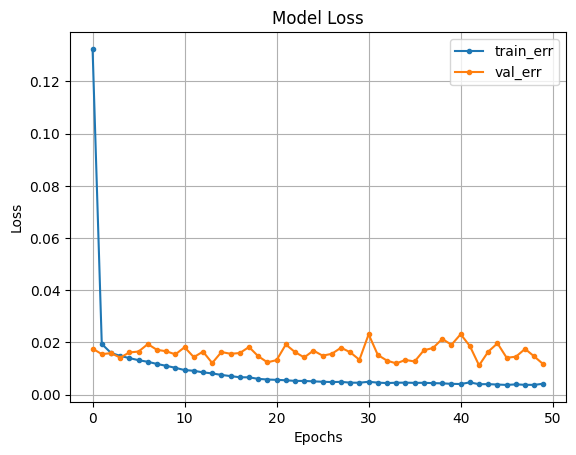

In [ ]:
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

In [ ]:
pred = model1.predict(x_val_s)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

2/2 [==============================] - 0s 15ms/step


In [ ]:
# 평가
print('RMSE :', np.sqrt(mean_squared_error(y_val, pred)))
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

RMSE : 4011.3130942176076
MAE : 3179.4976399739585
MAPE: 7.743395667511694e+17
R2  : -0.020804536217072345


34/34 [==============================] - 1s 12ms/step
* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.00416
* 자기상관성 확인(ACF, PACF)


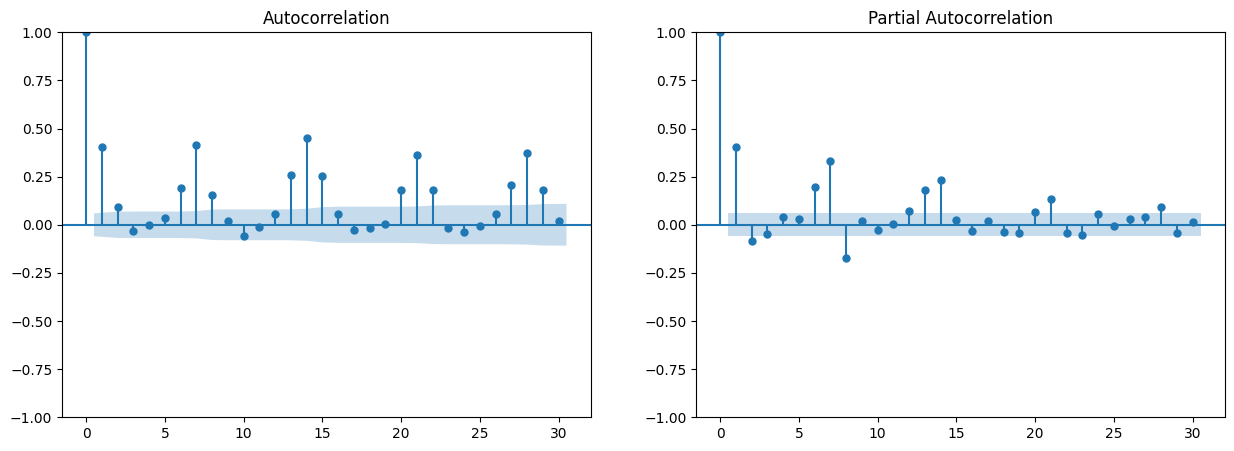

In [ ]:
import scipy.stats as spst
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def residual_diag(residuals, lags = 30) :
    print('* 정규성 검정(> 0.05) : ', round(spst.shapiro(residuals)[1],5))
    print('* 정상성 검정(< 0.05) : ', round(sm.tsa.stattools.adfuller(residuals)[1],5))
    print('* 자기상관성 확인(ACF, PACF)')
    fig,ax = plt.subplots(1,2, figsize = (15,5))
    plot_acf(residuals, lags = lags, ax = ax[0])
    plot_pacf(residuals, lags = lags, ax = ax[1])
    plt.show()
# train에 대한 잔차 진단.
pred_tr = model1.predict(x_train_s)

pred_tr = scaler_y.inverse_transform(pred_tr)
pred_tr = pred_tr.reshape(-1,)

# 잔차 : 실제값에서 예측값을 빼서 계산
residuals = y_train - pred_tr
residual_diag(residuals)

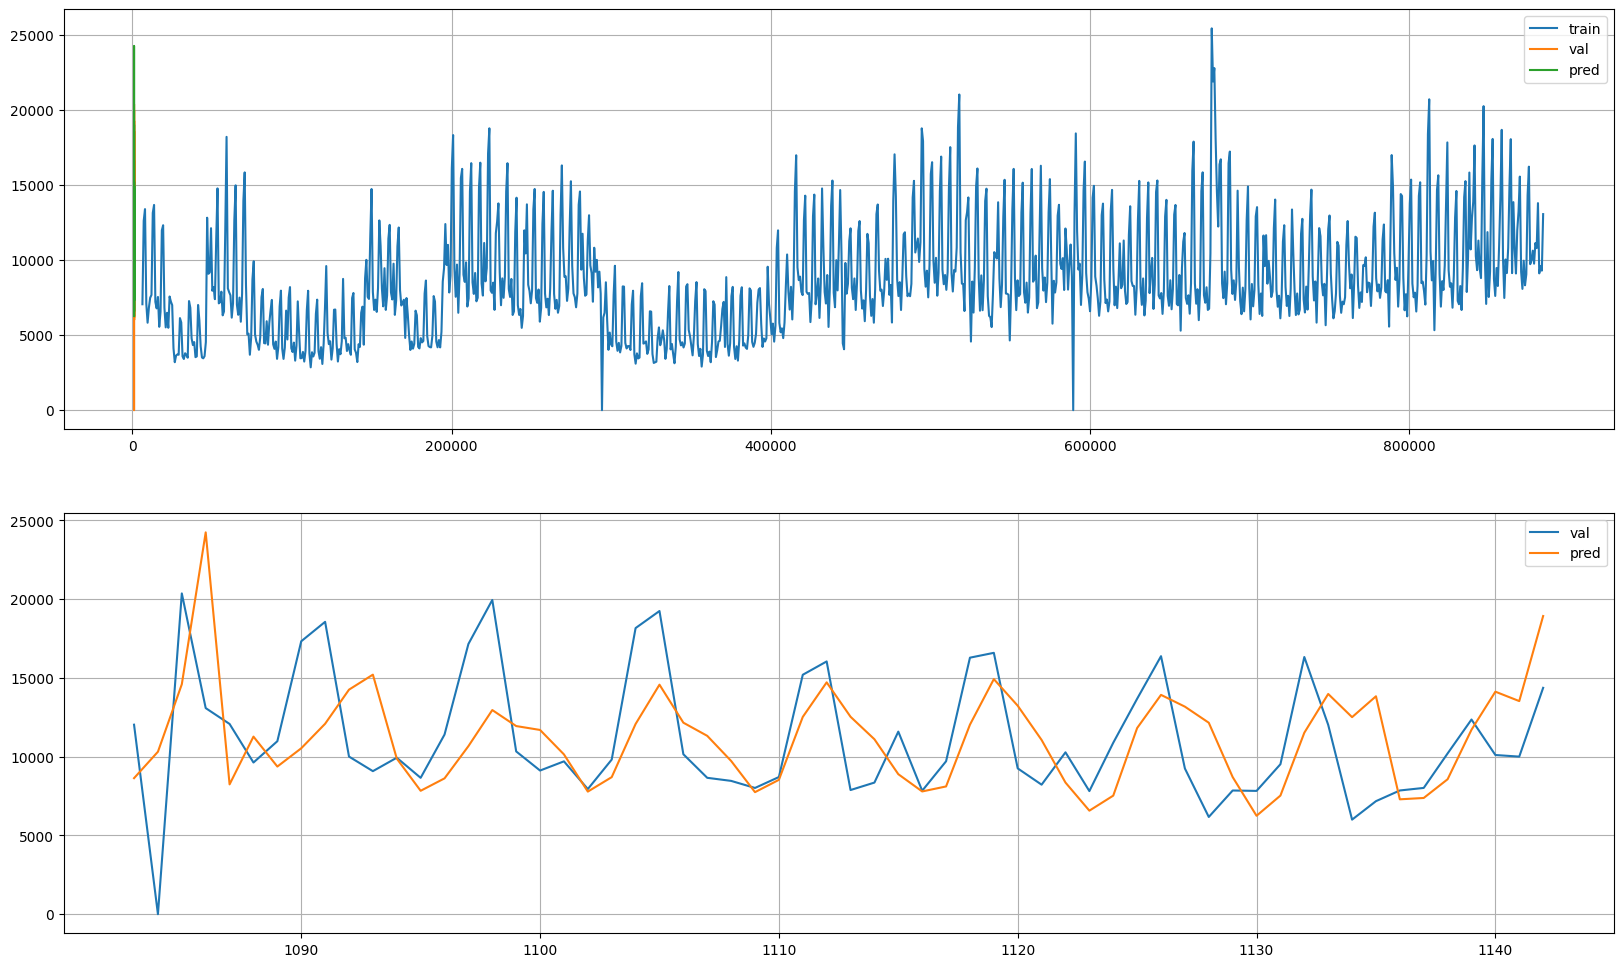

In [ ]:
plot_model_result(y_train, y_val, pred)

## **(2) 상품 : 12 - Milk**

### **1) 데이터 준비**

In [ ]:
target = 'After2'

X = sales_44_12.drop(target, axis=1)
y = sales_44_12[target]

In [ ]:
scaler_X = MinMaxScaler()
X = scaler_X.fit_transform(X)

scaler_Y = MinMaxScaler()
y = scaler_Y.fit_transform(y.values.reshape(-1,1))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=60, shuffle=False)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1091, 8), (60, 8), (1091, 1), (60, 1))

### **2) 모델링**

In [ ]:
nfeatures = X_train.shape[1]

clear_session()

model1 = Sequential([Dense(16, input_shape = (nfeatures,), activation = 'relu'),
                     Dense(32, activation='relu'),
                     Dense(16, activation='relu'),
                     Dense(1)])

model1.compile(optimizer= Adam(learning_rate = 0.01) , loss='mse')

In [ ]:
hist = model1.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[es, lr_reduction]).history

Epoch 1/100
35/35 [==============================] - 1s 7ms/step - loss: 0.0111 - val_loss: 0.0083 - lr: 0.0100
Epoch 2/100
35/35 [==============================] - 0s 3ms/step - loss: 0.0079 - val_loss: 0.0106 - lr: 0.0100
Epoch 3/100
35/35 [==============================] - 0s 3ms/step - loss: 0.0074 - val_loss: 0.0073 - lr: 0.0100
Epoch 4/100
35/35 [==============================] - 0s 3ms/step - loss: 0.0072 - val_loss: 0.0097 - lr: 0.0100
Epoch 5/100
35/35 [==============================] - 0s 3ms/step - loss: 0.0068 - val_loss: 0.0066 - lr: 0.0100
Epoch 6/100
35/35 [==============================] - 0s 3ms/step - loss: 0.0059 - val_loss: 0.0073 - lr: 0.0100
Epoch 7/100
35/35 [==============================] - 0s 3ms/step - loss: 0.0056 - val_loss: 0.0079 - lr: 0.0100
Epoch 8/100
35/35 [==============================] - 0s 3ms/step - loss: 0.0061 - val_loss: 0.0060 - lr: 0.0100
Epoch 9/100
35/35 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0049 - lr:

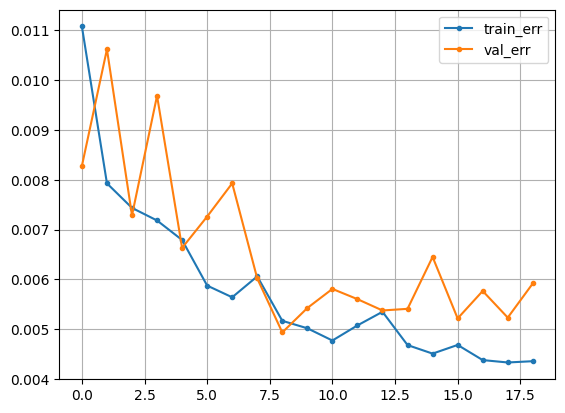

In [ ]:
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

In [ ]:
pred = model1.predict(X_val)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_Y.inverse_transform(pred)
pred = pred.reshape(-1,)

2/2 [==============================] - 0s 1ms/step


In [ ]:
# 평가
inverse_y_val = scaler_Y.inverse_transform(y_val).reshape(-1,)

print('RMSE :', mean_squared_error(inverse_y_val, pred, squared=False))
print('MAE :', mean_absolute_error(inverse_y_val, pred))
print('MAPE:', mean_absolute_percentage_error(inverse_y_val, pred))
print('R2  :', r2_score(inverse_y_val, pred))

RMSE : 2606.678132422174
MAE : 1855.6235188802084
MAPE: 0.15665522466526224
R2  : 0.34833486186691154


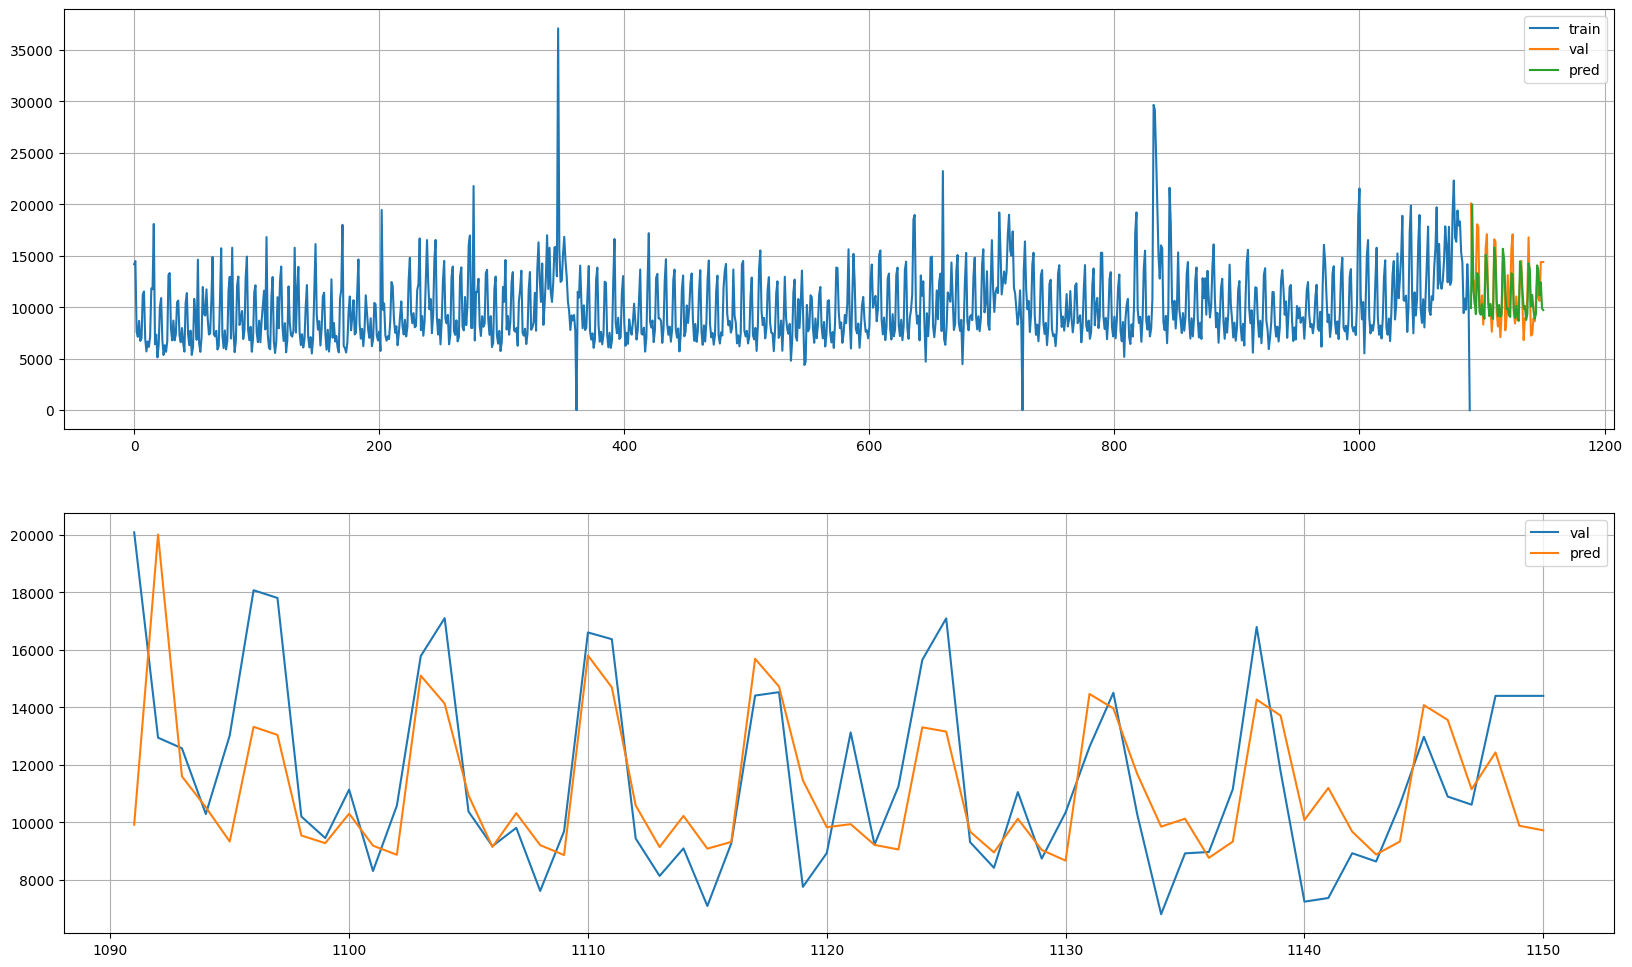

In [ ]:
inverse_y_train = scaler_Y.inverse_transform(y_train).reshape(-1,)
plot_model_result(inverse_y_train, inverse_y_val, pred)

## **(3) 상품 : 42 - Agricultural products**

### **1) 데이터 준비**

In [ ]:
target = 'y'

x = df_gro.drop(['Date', target], axis = 1)
y = df_gro.loc[:,target]

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size= 60, shuffle = False)

In [ ]:
# x에 대한 스케일링
scaler_x = MinMaxScaler()
x_train_s2 = scaler_x.fit_transform(x_train)
x_val_s2 = scaler_x.transform(x_val)

# y에 대한 스케일링(최적화를 위해)
scaler_y = MinMaxScaler()
y_train_s2 = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_val_s2 = scaler_y.transform(y_val.values.reshape(-1,1))

### **2) 모델링**

In [ ]:
nfeatures = x_train_s2.shape[1]

clear_session()

model1 = Sequential([Dense(64, input_shape = (nfeatures,), activation = 'relu'),
                     Dense(32, activation = 'relu'),
                     Dense(8, activation = 'relu'),
                     Dense(1)])

model1.compile(optimizer= Adam(learning_rate = 0.001) ,loss='mse', metrics=['mse'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2993 (11.69 KB)
Trainable params: 2993 (11.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
hist = model1.fit(x_train_s2, y_train_s2, epochs=50, validation_split=.2).history

Epoch 1/50
28/28 [==============================] - 1s 8ms/step - loss: 0.3804 - mse: 0.3804 - val_loss: 0.0652 - val_mse: 0.0652
Epoch 2/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0296 - mse: 0.0296 - val_loss: 0.0374 - val_mse: 0.0374
Epoch 3/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0232 - mse: 0.0232 - val_loss: 0.0320 - val_mse: 0.0320
Epoch 4/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0199 - mse: 0.0199 - val_loss: 0.0314 - val_mse: 0.0314
Epoch 5/50
28/28 [==============================] - 0s 3ms/step - loss: 0.0175 - mse: 0.0175 - val_loss: 0.0276 - val_mse: 0.0276
Epoch 6/50
28/28 [==============================] - 0s 4ms/step - loss: 0.0157 - mse: 0.0157 - val_loss: 0.0271 - val_mse: 0.0271
Epoch 7/50
28/28 [==============================] - 0s 3ms/step - loss: 0.0145 - mse: 0.0145 - val_loss: 0.0309 - val_mse: 0.0309
Epoch 8/50
28/28 [==============================] - 0s 3ms/step - loss: 0.0138 - mse: 0.01

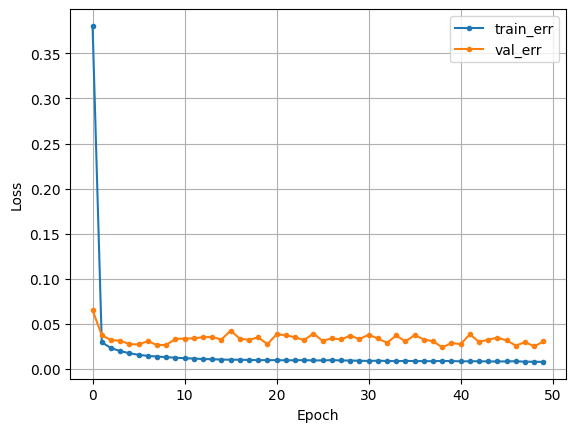

In [ ]:
dl_history_plot(hist)

In [ ]:
# 예측
pred = model1.predict(x_val_s2)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

2/2 [==============================] - 0s 6ms/step


In [ ]:
# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))
print('RMSE :', np.sqrt(mean_squared_error(y_val, pred)))

MAE : 25.23651212056478
MAPE: 0.31901054666577633
R2  : -2.8468858214564903
RMSE : 29.731732087325266


35/35 [==============================] - 0s 1ms/step
* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.46999
* 자기상관성 확인(ACF, PACF)


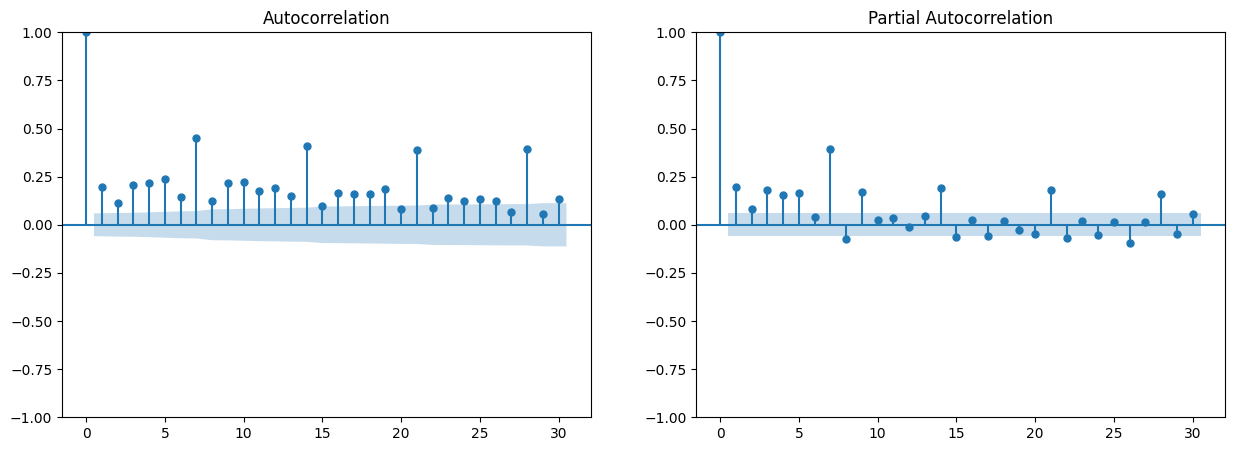

In [ ]:
import scipy.stats as spst
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def residual_diag(residuals, lags = 30) :
    print('* 정규성 검정(> 0.05) : ', round(spst.shapiro(residuals)[1],5))
    print('* 정상성 검정(< 0.05) : ', round(sm.tsa.stattools.adfuller(residuals)[1],5))
    print('* 자기상관성 확인(ACF, PACF)')
    fig,ax = plt.subplots(1,2, figsize = (15,5))
    plot_acf(residuals, lags = lags, ax = ax[0])
    plot_pacf(residuals, lags = lags, ax = ax[1])
    plt.show()
# train에 대한 잔차 진단.
pred_tr = model1.predict(x_train_s2)

pred_tr = scaler_y.inverse_transform(pred_tr)
pred_tr = pred_tr.reshape(-1,)

# 잔차 : 실제값에서 예측값을 빼서 계산
residuals = y_train - pred_tr
residual_diag(residuals)

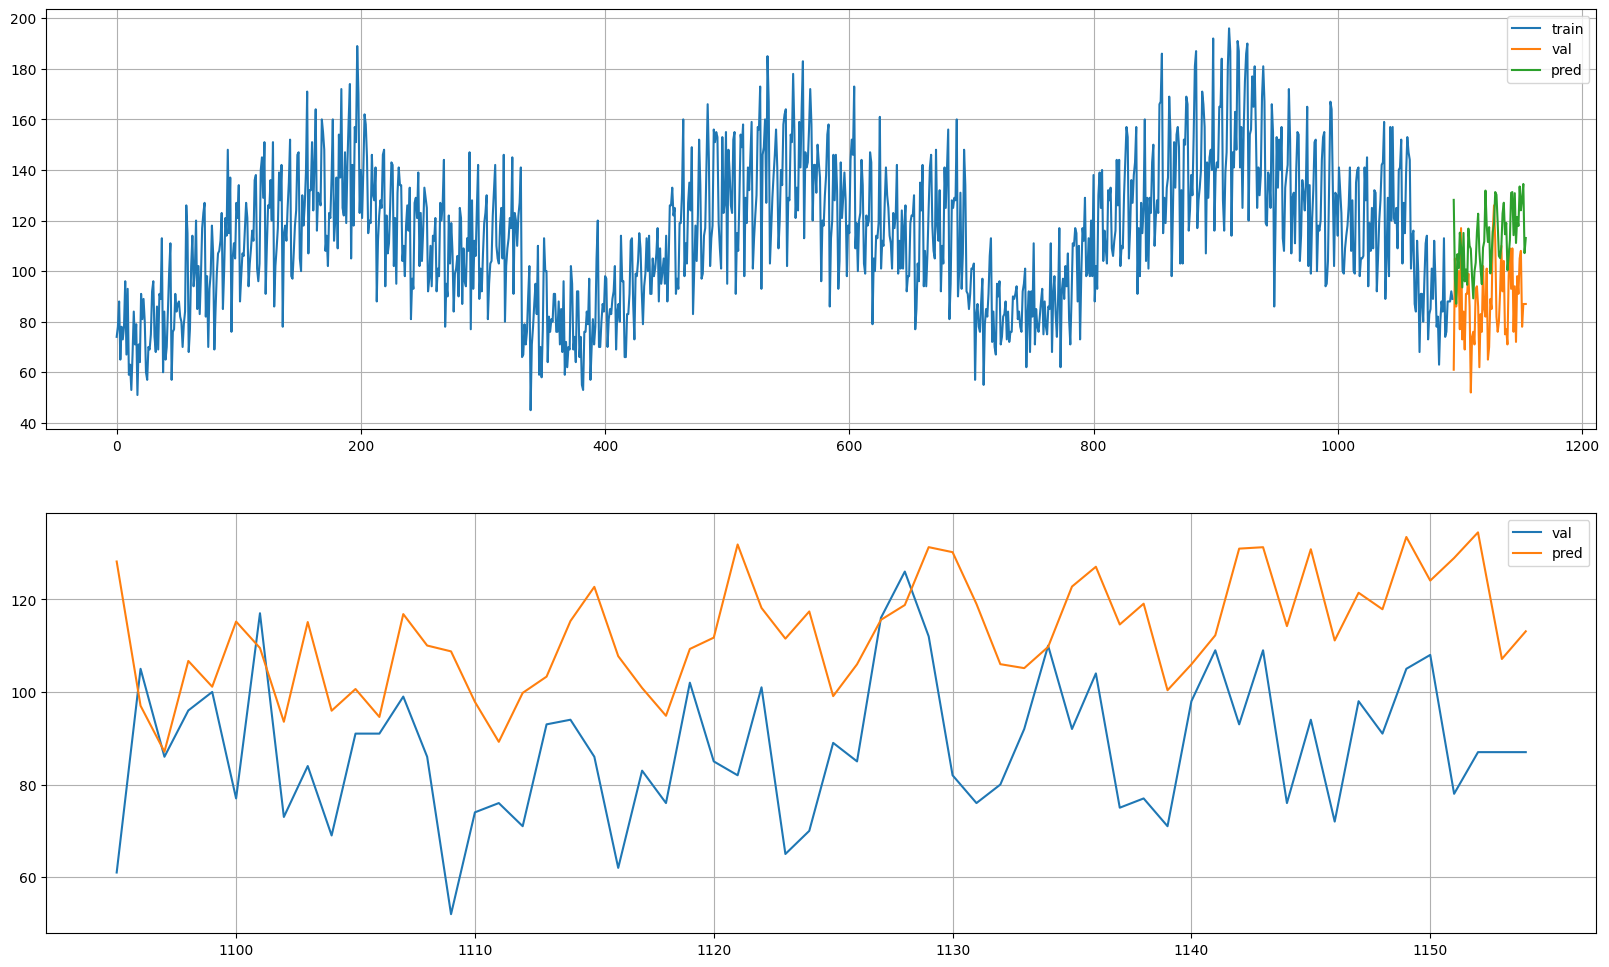

In [ ]:
plot_model_result(y_train, y_val, pred)

In [ ]:
!pip install shap

In [ ]:
# ExplainableAI 적용
# 변수중요도 분석

import shap

# SHAP 설명 객체 생성
explainer = shap.Explainer(model1, x_train_s2)

# SHAP 값 계산
shap_values = explainer(x_train_s2)

ExactExplainer explainer: 1096it [00:50, 19.51it/s]                          


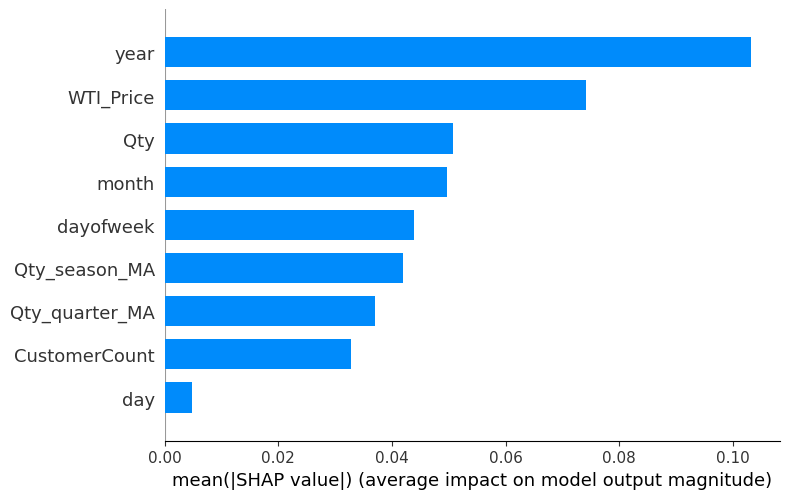

In [ ]:
# 요약 플롯 생성
shap.summary_plot(shap_values, x_train_s2, plot_type='bar', feature_names=x_train.columns)

# **4.LSTM, CNN 초기 모델**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.

In [ ]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

## **(1) LSTM 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [ ]:
timesteps = 24
x2, y2 = temporalize(x, y, timesteps) # 3차원 구조로 변환
x2.shape, y2.shape

((1120, 24, 17), (1120,))

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size= 60, shuffle = False)

In [ ]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return flattened_X

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
    return X

# 2차원으로 변환하여 스케일러 생성
scaler = MinMaxScaler().fit(flatten(x_train))

# 3차원 데이터에 스테일러 적용
x_train_s3 = scale(x_train, scaler)
x_val_s3 = scale(x_val, scaler)

# y에 대한 스케일링(최적화를 위해)
scaler_y = MinMaxScaler()
y_train_s3 = scaler_y.fit_transform(y_train.reshape(-1,1))
y_val_s3 = scaler_y.transform(y_val.reshape(-1,1))

In [ ]:
x_train_s3.shape, x_val_s3.shape, y_train_s3.shape, y_val_s3.shape

((1060, 24, 17), (60, 24, 17), (1060, 1), (60, 1))

* **모델링**

In [ ]:
n_features = x_train_s3.shape[2]

clear_session()

model2 = Sequential([
    LSTM(64, input_shape = (timesteps, nfeatures), return_sequences = True),
    LSTM(16, return_sequences = True),
    LSTM(4, return_sequences = True),
    Flatten(),
    Dense(1)
])

model2.compile(optimizer = Adam(learning_rate = 0.01), loss='mse', metrics=['mse'])
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 64)            20992     
                                                                 
 lstm_1 (LSTM)               (None, 24, 16)            5184      
                                                                 
 lstm_2 (LSTM)               (None, 24, 4)             336       
                                                                 
 flatten (Flatten)           (None, 96)                0         
                                                                 
 dense (Dense)               (None, 1)                 97        
                                                                 
Total params: 26609 (103.94 KB)
Trainable params: 26609 (103.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
x_train_s3.shape, y_train_s3.shape

((1060, 24, 17), (1060, 1))

In [ ]:
# history = model2.fit(x_train_s3, y_train_s3, epochs=30, validation_split=.2).history

history = model2.fit(x_train_s3, y_train_s3, epochs = 30, batch_size = 128,
                    validation_split=.2).history

Epoch 1/30
7/7 [==============================] - 9s 280ms/step - loss: 0.0420 - mse: 0.0420 - val_loss: 0.0288 - val_mse: 0.0288
Epoch 2/30
7/7 [==============================] - 1s 142ms/step - loss: 0.0223 - mse: 0.0223 - val_loss: 0.0243 - val_mse: 0.0243
Epoch 3/30
7/7 [==============================] - 1s 164ms/step - loss: 0.0210 - mse: 0.0210 - val_loss: 0.0164 - val_mse: 0.0164
Epoch 4/30
7/7 [==============================] - 1s 113ms/step - loss: 0.0195 - mse: 0.0195 - val_loss: 0.0163 - val_mse: 0.0163
Epoch 5/30
7/7 [==============================] - 1s 122ms/step - loss: 0.0186 - mse: 0.0186 - val_loss: 0.0151 - val_mse: 0.0151
Epoch 6/30
7/7 [==============================] - 1s 125ms/step - loss: 0.0175 - mse: 0.0175 - val_loss: 0.0146 - val_mse: 0.0146
Epoch 7/30
7/7 [==============================] - 1s 123ms/step - loss: 0.0168 - mse: 0.0168 - val_loss: 0.0140 - val_mse: 0.0140
Epoch 8/30
7/7 [==============================] - 1s 118ms/step - loss: 0.0166 - mse: 0.01

In [ ]:
feature_importance_df = get_feature_importance_dense(model1, feature_names)
print(feature_importance_df)

                   Feature  Importance
7              Qty_7D_mean    0.155056
3                dayofweek    0.149829
14             Qty_shift_1    0.147792
8    CustomerCount_7D_mean    0.146549
6                      Qty    0.144253
15             Qty_shift_2    0.143396
0                     year    0.141656
1                    month    0.138187
9        WTI_Price_7D_mean    0.136330
13           Qty_180D_mean    0.134310
2                      day    0.130968
4            CustomerCount    0.129790
11  CustomerCount_28D_mean    0.128782
16             Qty_shift_7    0.128684
10            Qty_28D_mean    0.125792
5                WTI_Price    0.123069
12            Qty_90D_mean    0.111381


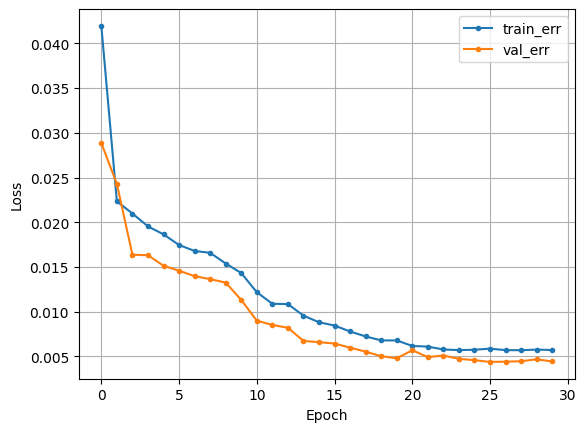

In [ ]:
dl_history_plot(history)

In [ ]:
pred = model2.predict(x_val_s3)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

2/2 [==============================] - 2s 17ms/step


In [ ]:
# 평가
print('RMSE :', np.sqrt(mean_squared_error(y_val, pred)))
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

RMSE : 3363.1570998401785
MAE : 2354.883553059896
MAPE: 1.0028114126324804e+18
R2  : 0.28243081876553644


In [ ]:
# train에 대한 잔차 진단.
pred_tr = model2.predict(x_train_s3)

pred_tr = scaler_y.inverse_transform(pred_tr)
pred_tr = pred_tr.reshape(-1,)

# 잔차 : 실제값에서 예측값을 빼서 계산
residuals = y_train - pred_tr

34/34 [==============================] - 1s 14ms/step


* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


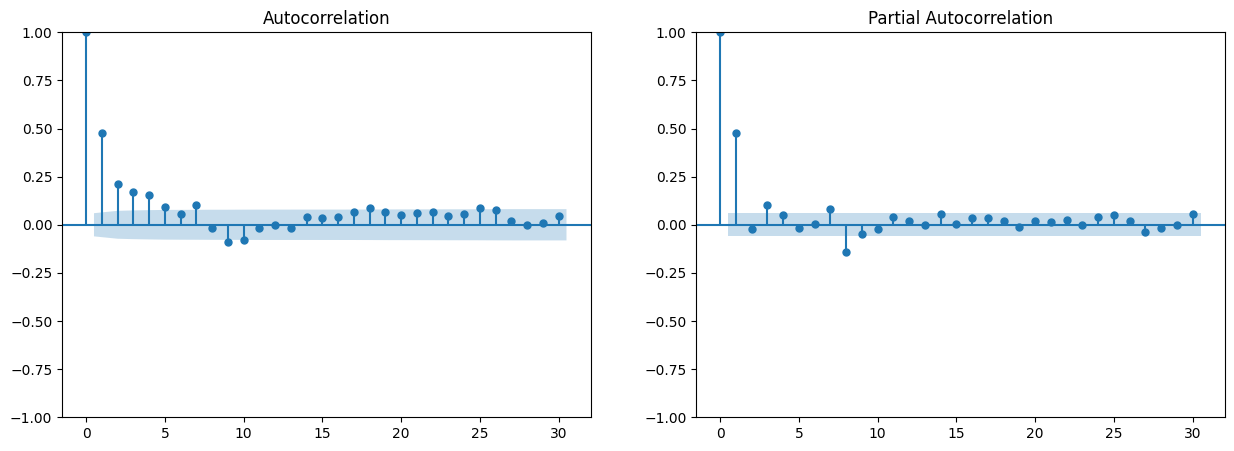

In [ ]:
residual_diag(residuals)

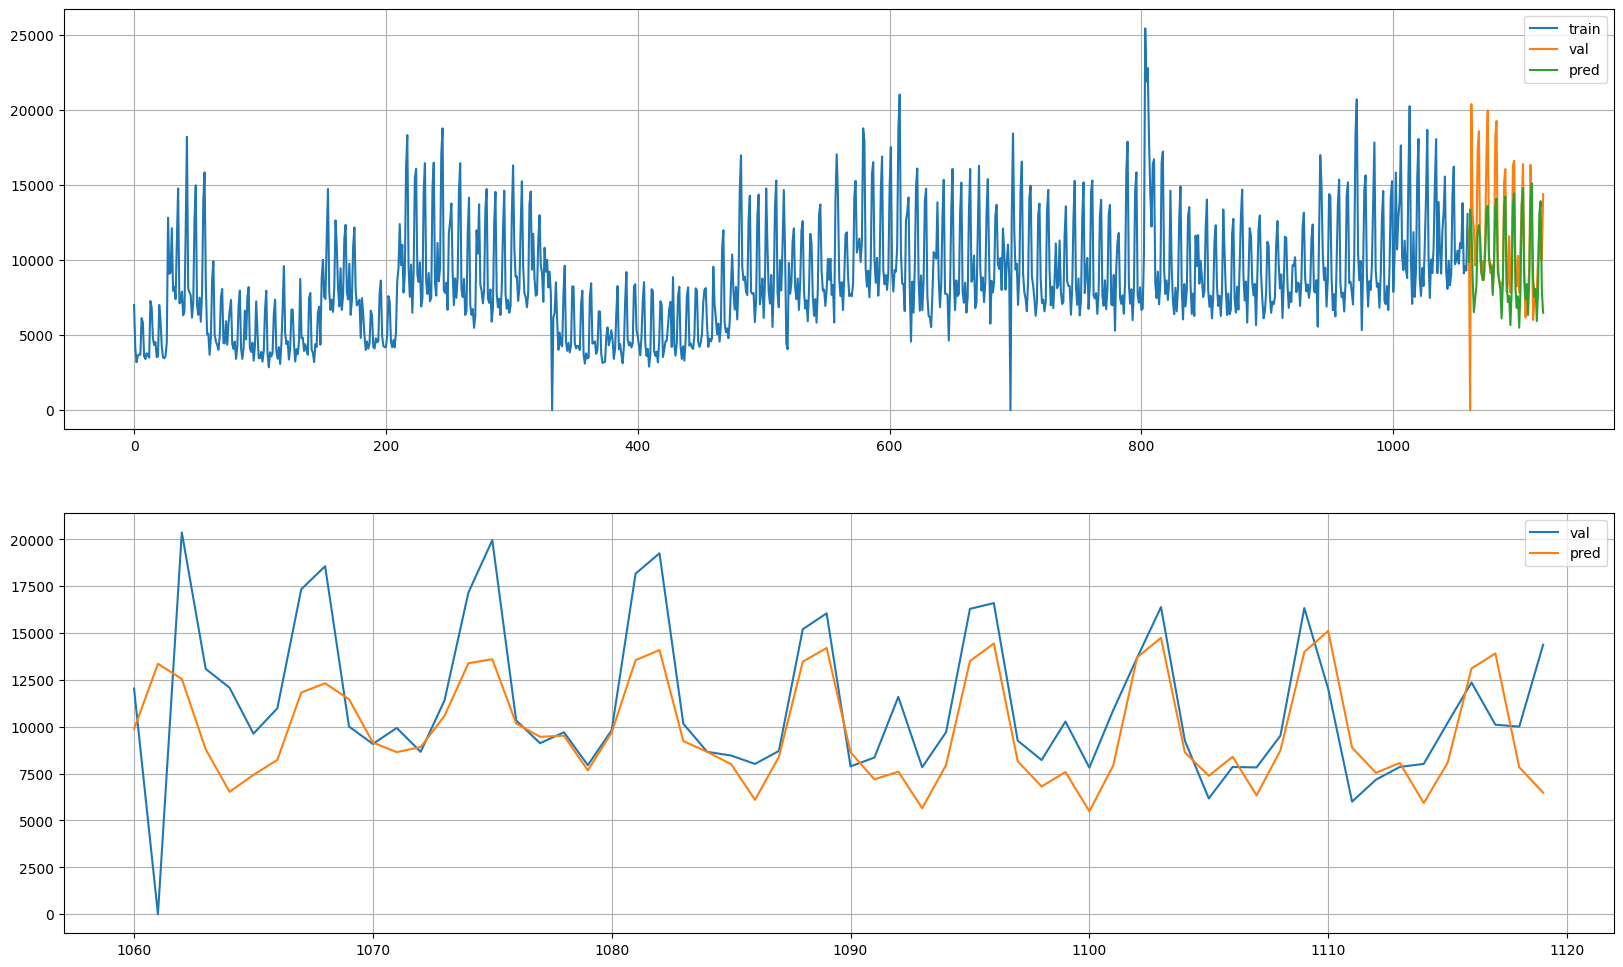

In [ ]:
plot_model_result(y_train, y_val, pred)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [ ]:
target = 'After2'

X = sales_44_12.drop(target, axis=1)
y = sales_44_12[target]

In [ ]:
# 스케일링
scaler_X = MinMaxScaler()
X = scaler_X.fit_transform(X)

scaler_Y = MinMaxScaler()
y = scaler_Y.fit_transform(y.values.reshape(-1,1))

X = pd.DataFrame(X)
y = pd.DataFrame(y)

In [ ]:
timesteps = 7
x2, y2 = temporalize(X, y, timesteps)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(x2, y2, test_size=60, shuffle=False)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1085, 7, 8), (60, 7, 8), (1085, 1), (60, 1))

* **모델링**

In [ ]:
n_features = X_train.shape[2]

clear_session()

model2 = Sequential([LSTM(32, input_shape = (timesteps, n_features)),
                     Dense(1)])

model2.compile(optimizer = Adam(learning_rate = 0.01), loss='mse')

In [ ]:
hist = model2.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[es, lr_reduction]).history

Epoch 1/100
34/34 [==============================] - 1s 14ms/step - loss: 0.0136 - val_loss: 0.0073 - lr: 0.0100
Epoch 2/100
34/34 [==============================] - 0s 4ms/step - loss: 0.0080 - val_loss: 0.0075 - lr: 0.0100
Epoch 3/100
34/34 [==============================] - 0s 5ms/step - loss: 0.0075 - val_loss: 0.0063 - lr: 0.0100
Epoch 4/100
34/34 [==============================] - 0s 5ms/step - loss: 0.0069 - val_loss: 0.0092 - lr: 0.0100
Epoch 5/100
34/34 [==============================] - 0s 5ms/step - loss: 0.0064 - val_loss: 0.0053 - lr: 0.0100
Epoch 6/100
34/34 [==============================] - 0s 4ms/step - loss: 0.0062 - val_loss: 0.0053 - lr: 0.0100
Epoch 7/100
34/34 [==============================] - 0s 5ms/step - loss: 0.0050 - val_loss: 0.0042 - lr: 0.0100
Epoch 8/100
34/34 [==============================] - 0s 5ms/step - loss: 0.0051 - val_loss: 0.0056 - lr: 0.0100
Epoch 9/100
34/34 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0058 - lr

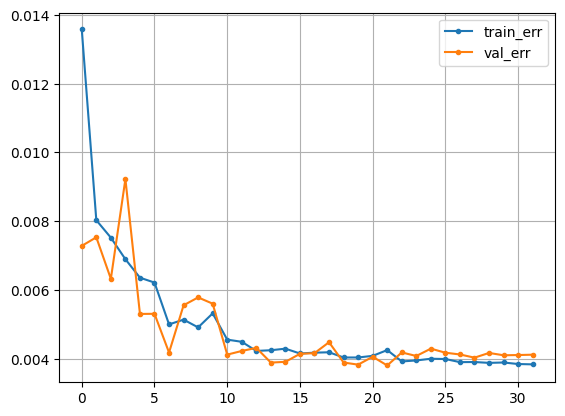

In [ ]:
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

In [ ]:
pred = model2.predict(X_val)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_Y.inverse_transform(pred)
pred = pred.reshape(-1,)

2/2 [==============================] - 0s 3ms/step


In [ ]:
# 평가
inverse_y_val = scaler_Y.inverse_transform(y_val).reshape(-1,)

print('RMSE :', mean_squared_error(inverse_y_val, pred, squared=False))
print('MAE :', mean_absolute_error(inverse_y_val, pred))
print('MAPE:', mean_absolute_percentage_error(inverse_y_val, pred))
print('R2  :', r2_score(inverse_y_val, pred))

RMSE : 2287.079341072813
MAE : 1619.371240234375
MAPE: 0.14244357005575348
R2  : 0.4983369282979361


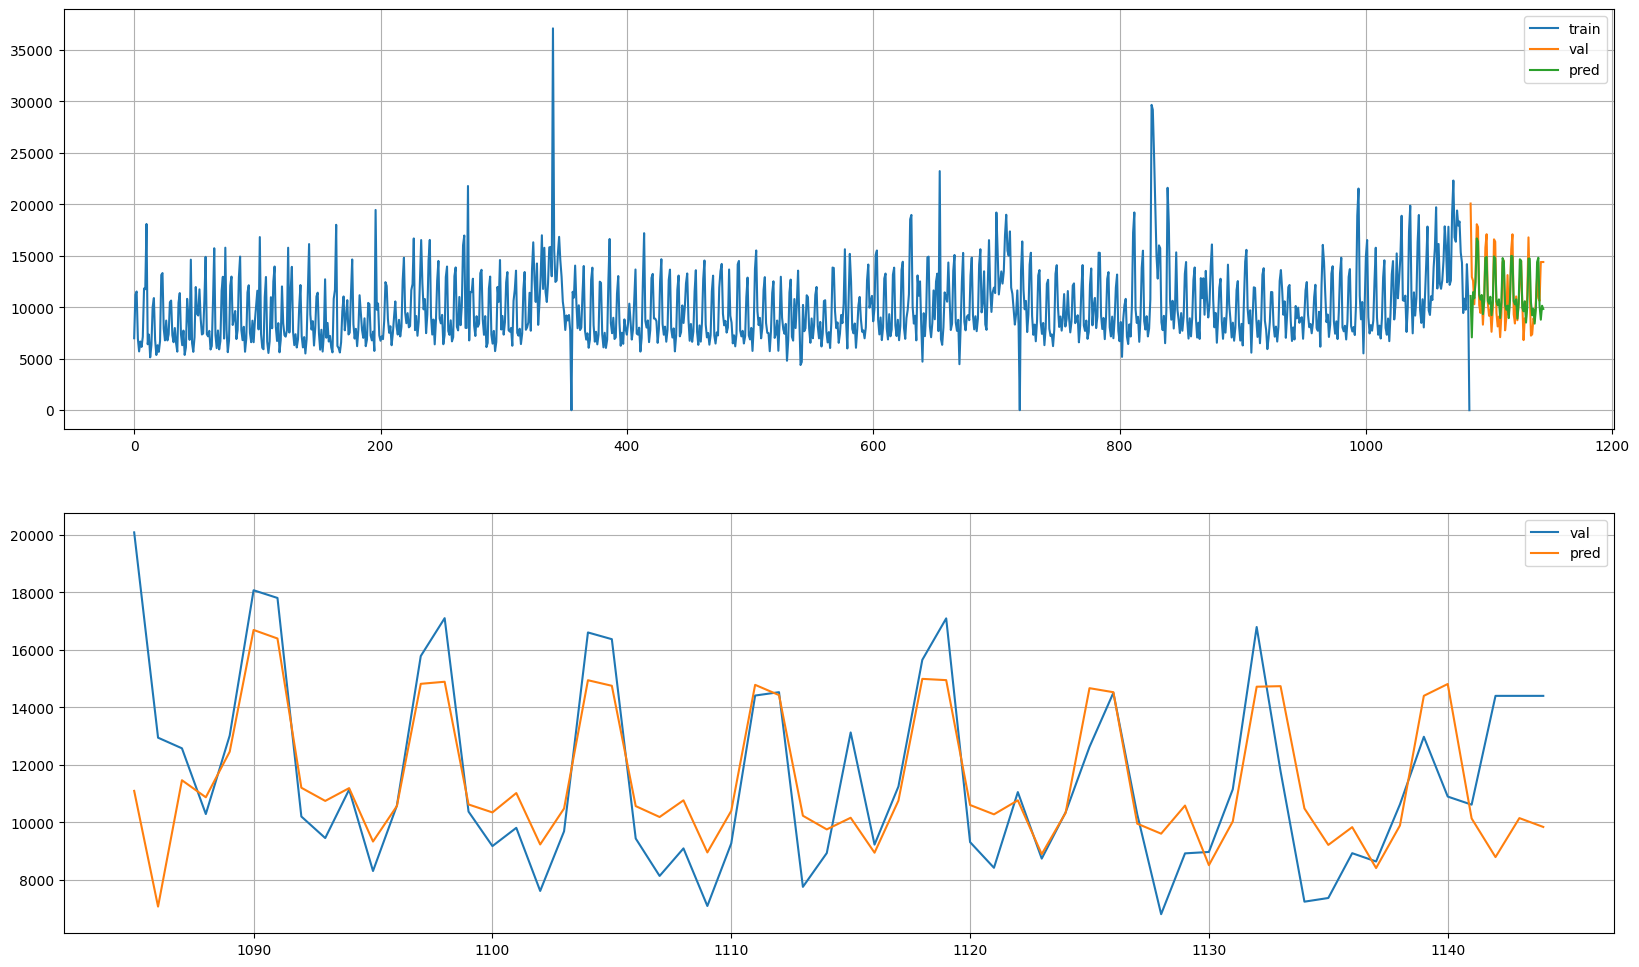

In [ ]:
inverse_y_train = scaler_Y.inverse_transform(y_train).reshape(-1,)
plot_model_result(inverse_y_train, inverse_y_val, pred)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [ ]:
timesteps = 90
x2, y2 = temporalize(x, y, timesteps) # 3차원 구조로 변환
x2.shape, y2.shape

((1066, 90, 9), (1066,))

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size= 60, shuffle = False)

In [ ]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return flattened_X

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
    return X

# 2차원으로 변환하여 스케일러 생성
scaler = MinMaxScaler().fit(flatten(x_train))

# 3차원 데이터에 스테일러 적용
x_train_s3 = scale(x_train, scaler)
x_val_s3 = scale(x_val, scaler)

# y에 대한 스케일링(최적화를 위해)
scaler_y = MinMaxScaler()
y_train_s3 = scaler_y.fit_transform(y_train.reshape(-1,1))
y_val_s3 = scaler_y.transform(y_val.reshape(-1,1))

In [ ]:
x_train_s3.shape, x_val_s3.shape, y_train_s3.shape, y_val_s3.shape

((1006, 90, 9), (60, 90, 9), (1006, 1), (60, 1))

* **모델링**

In [ ]:
n_features = x_train_s3.shape[2]

clear_session()

model2 = Sequential([
    LSTM(64, input_shape = (timesteps, nfeatures), return_sequences = True),
    LSTM(16, return_sequences = True),
    LSTM(4, return_sequences = True),
    Flatten(),
    Dense(1)
])

model2.compile(optimizer = Adam(learning_rate = 0.01), loss='mse', metrics=['mse'])
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 90, 64)            18944     
                                                                 
 lstm_1 (LSTM)               (None, 90, 16)            5184      
                                                                 
 lstm_2 (LSTM)               (None, 90, 4)             336       
                                                                 
 flatten (Flatten)           (None, 360)               0         
                                                                 
 dense (Dense)               (None, 1)                 361       
                                                                 
Total params: 24825 (96.97 KB)
Trainable params: 24825 (96.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
x_train_s3.shape, y_train_s3.shape

((1006, 90, 9), (1006, 1))

In [ ]:
# history = model2.fit(x_train_s3, y_train_s3, epochs=30, validation_split=.2).history

history = model2.fit(x_train_s3, y_train_s3, epochs = 30, batch_size = 128,
                    validation_split=.2).history

Epoch 1/30
7/7 [==============================] - 8s 386ms/step - loss: 0.2825 - mse: 0.2825 - val_loss: 0.0351 - val_mse: 0.0351
Epoch 2/30
7/7 [==============================] - 1s 183ms/step - loss: 0.0447 - mse: 0.0447 - val_loss: 0.0358 - val_mse: 0.0358
Epoch 3/30
7/7 [==============================] - 2s 260ms/step - loss: 0.0378 - mse: 0.0378 - val_loss: 0.0369 - val_mse: 0.0369
Epoch 4/30
7/7 [==============================] - 2s 319ms/step - loss: 0.0377 - mse: 0.0377 - val_loss: 0.0516 - val_mse: 0.0516
Epoch 5/30
7/7 [==============================] - 2s 237ms/step - loss: 0.0354 - mse: 0.0354 - val_loss: 0.0504 - val_mse: 0.0504
Epoch 6/30
7/7 [==============================] - 1s 183ms/step - loss: 0.0326 - mse: 0.0326 - val_loss: 0.0508 - val_mse: 0.0508
Epoch 7/30
7/7 [==============================] - 1s 190ms/step - loss: 0.0344 - mse: 0.0344 - val_loss: 0.0568 - val_mse: 0.0568
Epoch 8/30
7/7 [==============================] - 1s 183ms/step - loss: 0.0321 - mse: 0.03

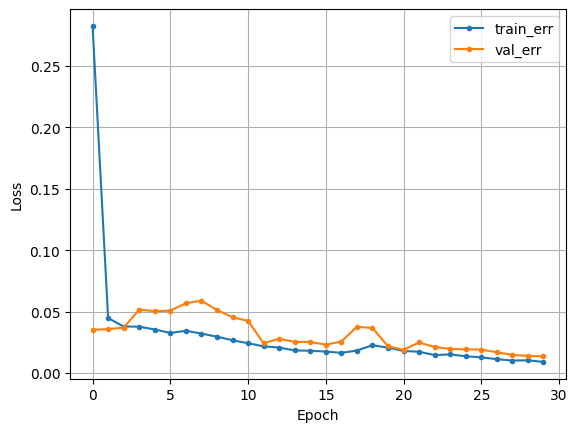

In [ ]:
dl_history_plot(history)

In [ ]:
pred = model2.predict(x_val_s3)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

2/2 [==============================] - 1s 27ms/step


In [ ]:
# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))
print('RMSE :', np.sqrt(mean_squared_error(y_val, pred)))

MAE : 12.186913045247396
MAPE: 0.15156915513528293
R2  : 0.07786431627582946
RMSE : 14.556701506968436


In [ ]:
# train에 대한 잔차 진단.
pred_tr = model2.predict(x_train_s3)

pred_tr = scaler_y.inverse_transform(pred_tr)
pred_tr = pred_tr.reshape(-1,)

# 잔차 : 실제값에서 예측값을 빼서 계산
residuals = y_train - pred_tr

32/32 [==============================] - 1s 39ms/step


* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  2e-05
* 자기상관성 확인(ACF, PACF)


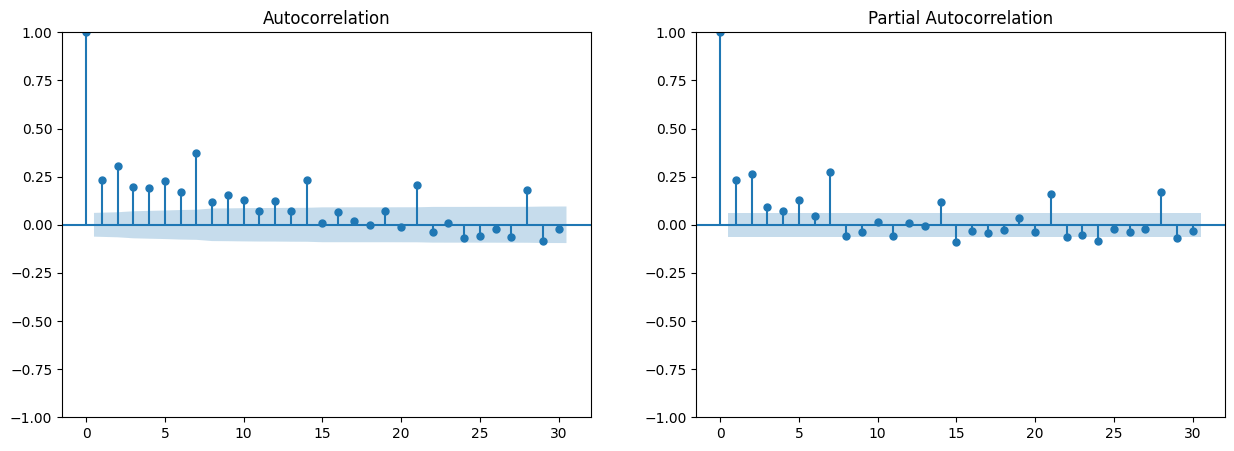

In [ ]:
residual_diag(residuals)

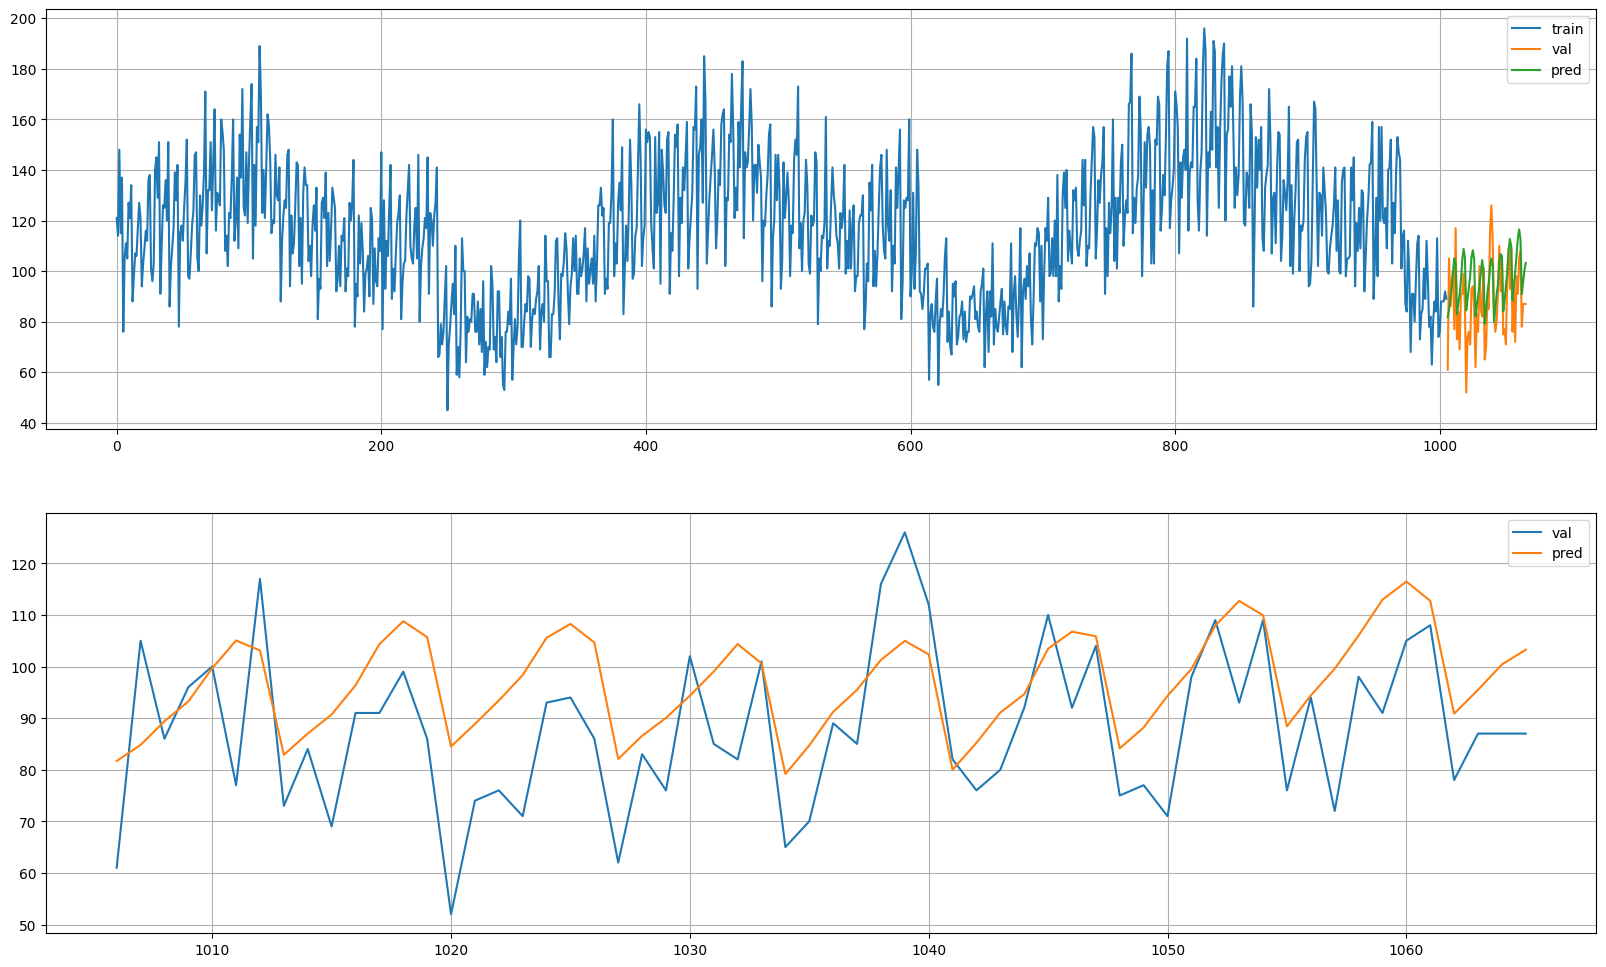

In [ ]:
plot_model_result(y_train, y_val, pred)

## **(2) CNN 초기 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [ ]:
n_features = x_train.shape[2]

clear_session()

model3 = Sequential([Conv1D(32, 5, input_shape = (timesteps, n_features), activation='relu', padding = 'same'),
                    Flatten(),
                    Dense(1)])

model3.compile(optimizer= Adam(learning_rate = 0.01) ,loss='mse')
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 24, 32)            2752      
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 1)                 769       
                                                                 
Total params: 3521 (13.75 KB)
Trainable params: 3521 (13.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


* **모델링**

In [ ]:
x_train_s3.shape, y_train_s3.shape

((1060, 24, 17), (1060, 1))

In [ ]:
hist = model3.fit(x_train_s3, y_train_s3, epochs=30, validation_split=.2).history

Epoch 1/30
27/27 [==============================] - 1s 10ms/step - loss: 0.3434 - val_loss: 0.1275
Epoch 2/30
27/27 [==============================] - 0s 4ms/step - loss: 0.0609 - val_loss: 0.0558
Epoch 3/30
27/27 [==============================] - 0s 5ms/step - loss: 0.0276 - val_loss: 0.0287
Epoch 4/30
27/27 [==============================] - 0s 5ms/step - loss: 0.0208 - val_loss: 0.0213
Epoch 5/30
27/27 [==============================] - 0s 4ms/step - loss: 0.0202 - val_loss: 0.0201
Epoch 6/30
27/27 [==============================] - 0s 5ms/step - loss: 0.0202 - val_loss: 0.0202
Epoch 7/30
27/27 [==============================] - 0s 4ms/step - loss: 0.0202 - val_loss: 0.0202
Epoch 8/30
27/27 [==============================] - 0s 4ms/step - loss: 0.0202 - val_loss: 0.0201
Epoch 9/30
27/27 [==============================] - 0s 5ms/step - loss: 0.0202 - val_loss: 0.0201
Epoch 10/30
27/27 [==============================] - 0s 4ms/step - loss: 0.0202 - val_loss: 0.0200
Epoch 11/30
27/27 

In [ ]:
feature_importance_df = get_feature_importance_dense(model1, feature_names)
print(feature_importance_df)

                   Feature  Importance
7              Qty_7D_mean    0.155056
3                dayofweek    0.149829
14             Qty_shift_1    0.147792
8    CustomerCount_7D_mean    0.146549
6                      Qty    0.144253
15             Qty_shift_2    0.143396
0                     year    0.141656
1                    month    0.138187
9        WTI_Price_7D_mean    0.136330
13           Qty_180D_mean    0.134310
2                      day    0.130968
4            CustomerCount    0.129790
11  CustomerCount_28D_mean    0.128782
16             Qty_shift_7    0.128684
10            Qty_28D_mean    0.125792
5                WTI_Price    0.123069
12            Qty_90D_mean    0.111381


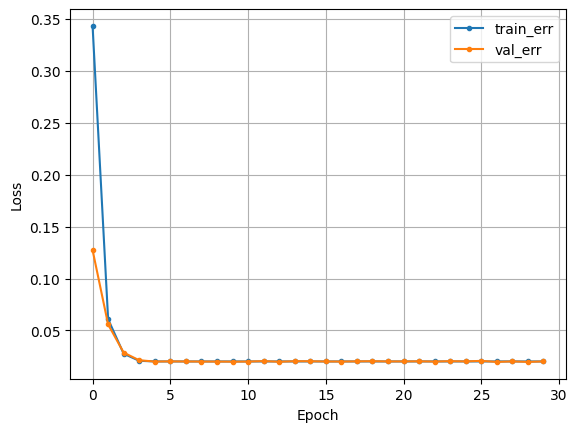

In [ ]:
dl_history_plot(hist)

In [ ]:
pred = model3.predict(x_val_s3)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

2/2 [==============================] - 0s 5ms/step


In [ ]:
# 평가
print('RMSE :', np.sqrt(mean_squared_error(y_val, pred)))
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))

RMSE : 4939.917605990494
MAE : 3489.2454752604167
MAPE: 6.172719117977868e+17
R2  : -0.5481351790766777


In [ ]:
# train에 대한 잔차 진단.
pred_tr = model2.predict(x_train_s3)

pred_tr = scaler_y.inverse_transform(pred_tr)
pred_tr = pred_tr.reshape(-1,)

# 잔차 : 실제값에서 예측값을 빼서 계산
residuals = y_train - pred_tr

34/34 [==============================] - 1s 9ms/step


* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  0.0
* 자기상관성 확인(ACF, PACF)


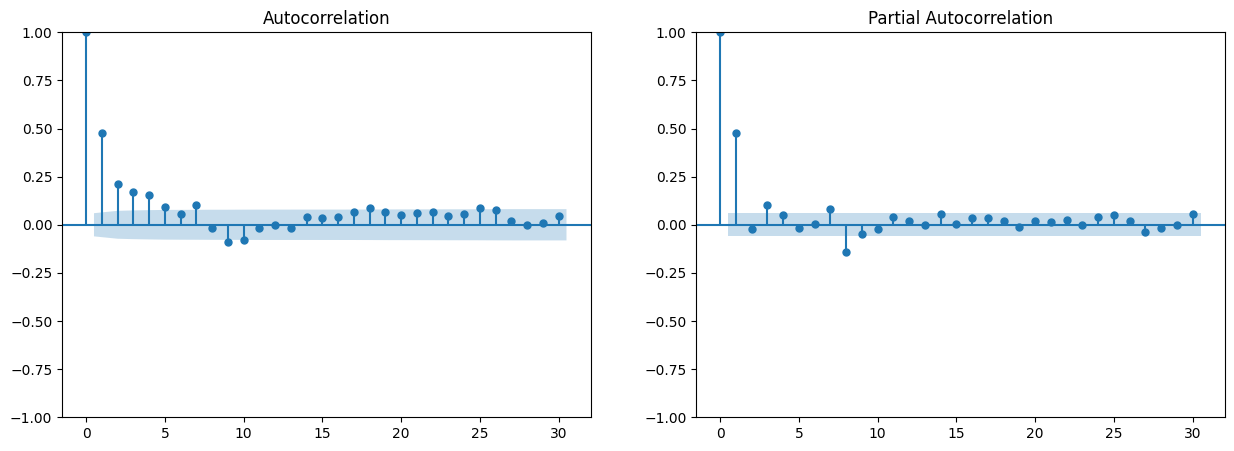

In [ ]:
residual_diag(residuals)

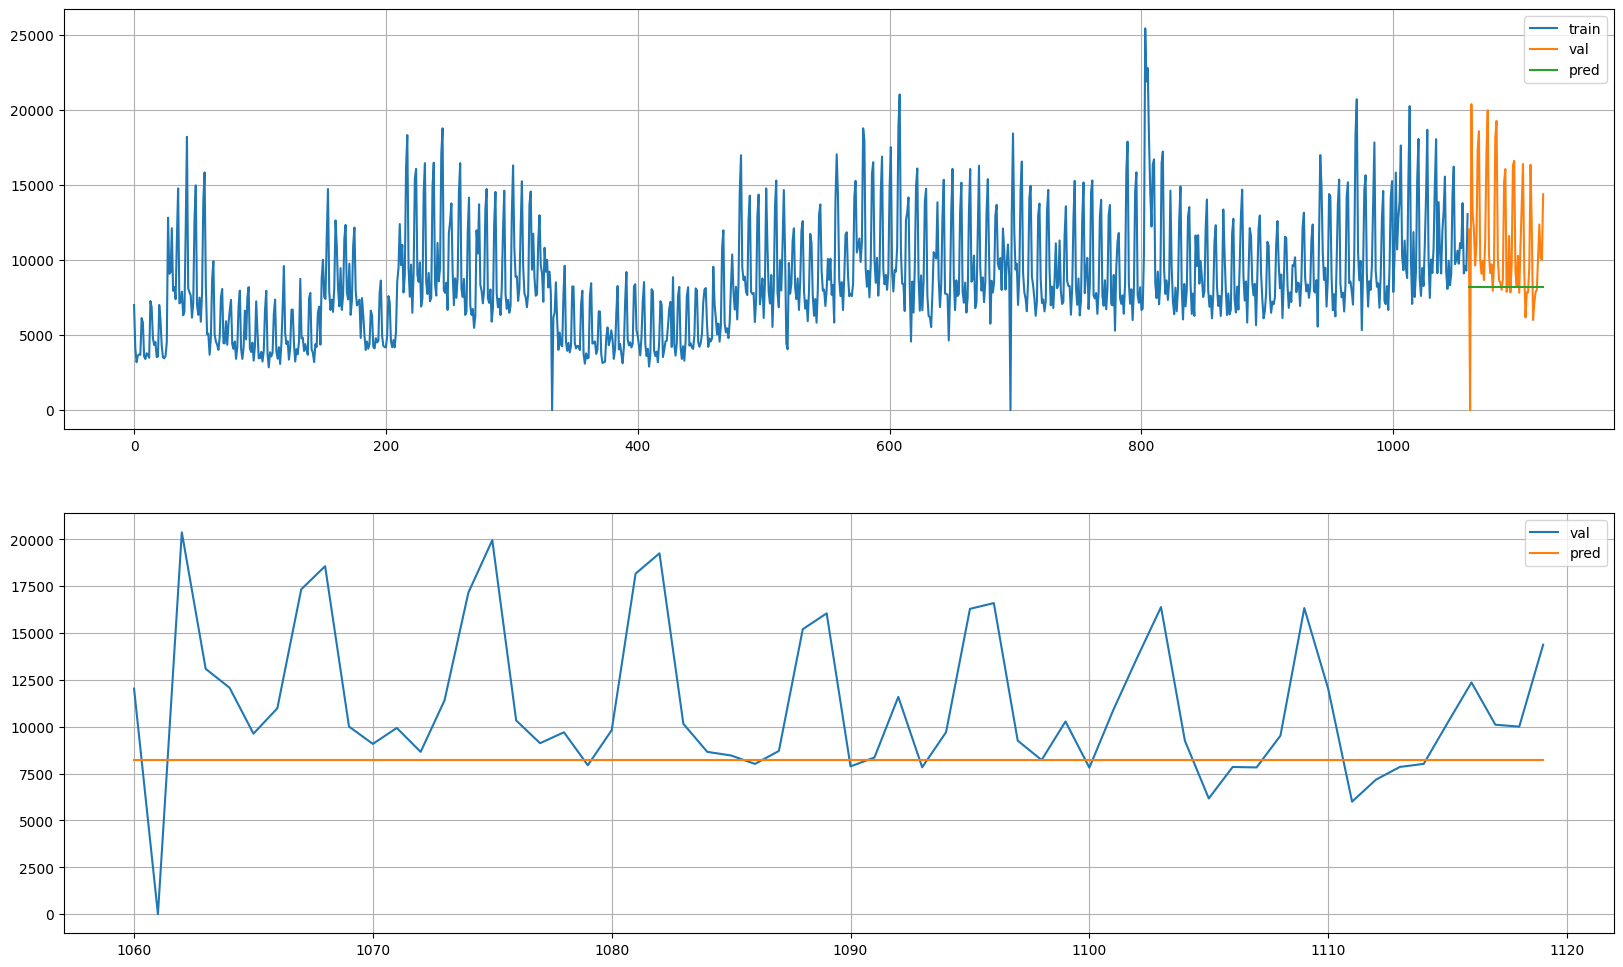

In [ ]:
plot_model_result(y_train, y_val, pred)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

LSTM과 동일한 데이터

* **모델링**

In [ ]:
n_features = X_train.shape[2]

clear_session()

model3 = Sequential([Conv1D(32, 5, input_shape = (timesteps, n_features), activation='relu', padding = 'same'),
                    Flatten(),
                    Dense(1)])

model3.compile(optimizer= Adam(learning_rate = 0.01) , loss='mse')

In [ ]:
hist = model3.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val)).history

Epoch 1/30
34/34 [==============================] - 1s 6ms/step - loss: 0.0598 - val_loss: 0.0078
Epoch 2/30
34/34 [==============================] - 0s 3ms/step - loss: 0.0071 - val_loss: 0.0059
Epoch 3/30
34/34 [==============================] - 0s 3ms/step - loss: 0.0060 - val_loss: 0.0051
Epoch 4/30
34/34 [==============================] - 0s 3ms/step - loss: 0.0066 - val_loss: 0.0129
Epoch 5/30
34/34 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.0037
Epoch 6/30
34/34 [==============================] - 0s 4ms/step - loss: 0.0052 - val_loss: 0.0040
Epoch 7/30
34/34 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 8/30
34/34 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 9/30
34/34 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0037
Epoch 10/30
34/34 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0038
Epoch 11/30
34/34 [

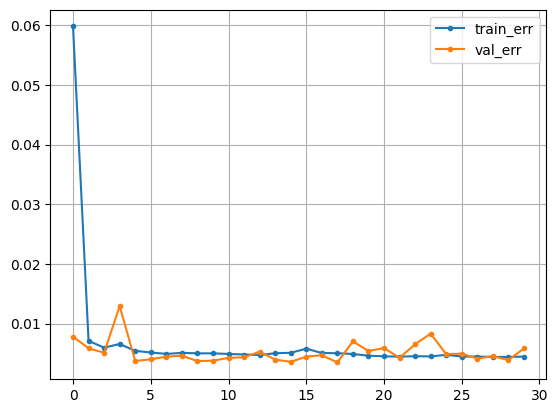

In [ ]:
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

In [ ]:
pred = model3.predict(X_val)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_Y.inverse_transform(pred)
pred = pred.reshape(-1,)

2/2 [==============================] - 0s 2ms/step


In [ ]:
# 평가
inverse_y_val = scaler_Y.inverse_transform(y_val).reshape(-1,)

print('RMSE :', mean_squared_error(inverse_y_val, pred, squared=False))
print('MAE :', mean_absolute_error(inverse_y_val, pred))
print('MAPE:', mean_absolute_percentage_error(inverse_y_val, pred))
print('R2  :', r2_score(inverse_y_val, pred))

RMSE : 2834.7727047715853
MAE : 2228.337451171875
MAPE: 0.17757104393750878
R2  : 0.22929858581143348


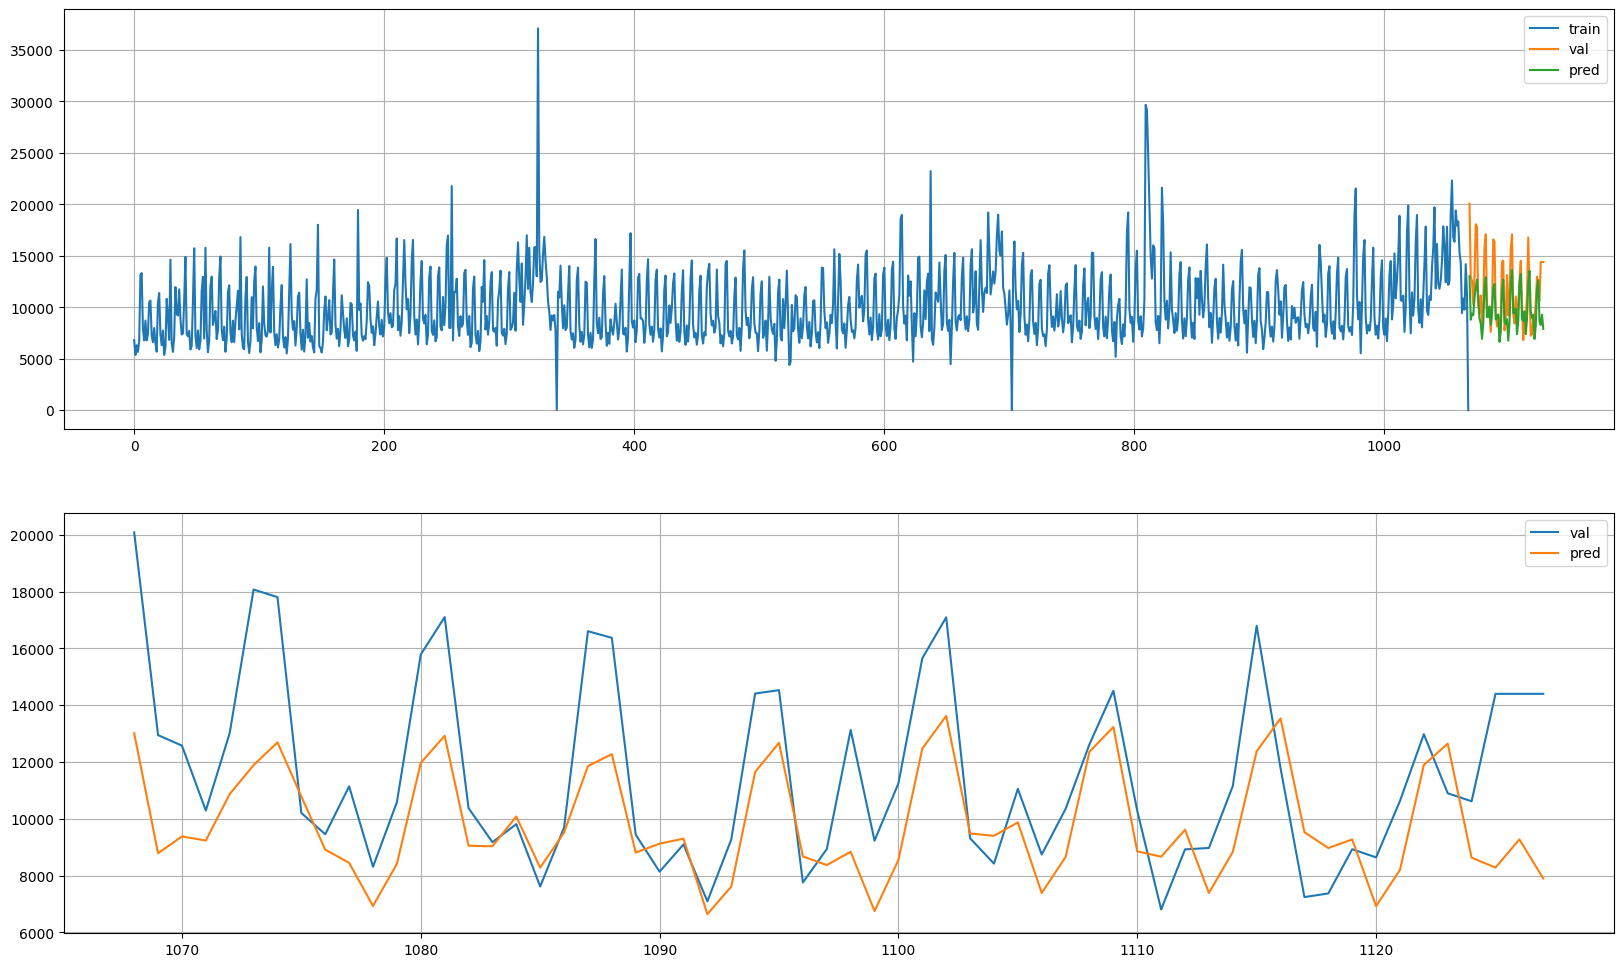

In [ ]:
inverse_y_train = scaler_Y.inverse_transform(y_train).reshape(-1,)
plot_model_result(inverse_y_train, inverse_y_val, pred)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [ ]:
timesteps = 30
x2, y2 = temporalize(x, y, timesteps) # 3차원 구조로 변환
x2.shape, y2.shape

((1126, 30, 9), (1126,))

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size= 60, shuffle = False)

In [ ]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return flattened_X

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
    return X

# 2차원으로 변환하여 스케일러 생성
scaler = MinMaxScaler().fit(flatten(x_train))

# 3차원 데이터에 스테일러 적용
x_train_s3 = scale(x_train, scaler)
x_val_s3 = scale(x_val, scaler)

# y에 대한 스케일링(최적화를 위해)
scaler_y = MinMaxScaler()
y_train_s3 = scaler_y.fit_transform(y_train.reshape(-1,1))
y_val_s3 = scaler_y.transform(y_val.reshape(-1,1))

In [ ]:
x_train_s3.shape, x_val_s3.shape, y_train_s3.shape, y_val_s3.shape

((1066, 30, 9), (60, 30, 9), (1066, 1), (60, 1))

In [ ]:
n_features = x_train.shape[2]

clear_session()

model3 = Sequential([Conv1D(32, 5, input_shape = (timesteps, n_features), activation='relu', padding = 'same'),
                    Flatten(),
                    Dense(1)])

model3.compile(optimizer= Adam(learning_rate = 0.01) ,loss='mse')
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 32)            1472      
                                                                 
 flatten (Flatten)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 1)                 961       
                                                                 
Total params: 2433 (9.50 KB)
Trainable params: 2433 (9.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
x_train_s3.shape, y_train_s3.shape

((1066, 30, 9), (1066, 1))

* **모델링**

In [ ]:
hist = model3.fit(x_train_s3, y_train_s3, epochs=30, validation_split=.2).history

Epoch 1/30
27/27 [==============================] - 1s 9ms/step - loss: 0.2714 - val_loss: 0.0695
Epoch 2/30
27/27 [==============================] - 0s 4ms/step - loss: 0.0274 - val_loss: 0.0436
Epoch 3/30
27/27 [==============================] - 0s 4ms/step - loss: 0.0155 - val_loss: 0.0187
Epoch 4/30
27/27 [==============================] - 0s 5ms/step - loss: 0.0113 - val_loss: 0.0183
Epoch 5/30
27/27 [==============================] - 0s 4ms/step - loss: 0.0089 - val_loss: 0.0137
Epoch 6/30
27/27 [==============================] - 0s 4ms/step - loss: 0.0081 - val_loss: 0.0106
Epoch 7/30
27/27 [==============================] - 0s 4ms/step - loss: 0.0079 - val_loss: 0.0113
Epoch 8/30
27/27 [==============================] - 0s 4ms/step - loss: 0.0094 - val_loss: 0.0099
Epoch 9/30
27/27 [==============================] - 0s 4ms/step - loss: 0.0073 - val_loss: 0.0100
Epoch 10/30
27/27 [==============================] - 0s 4ms/step - loss: 0.0071 - val_loss: 0.0101
Epoch 11/30
27/27 [

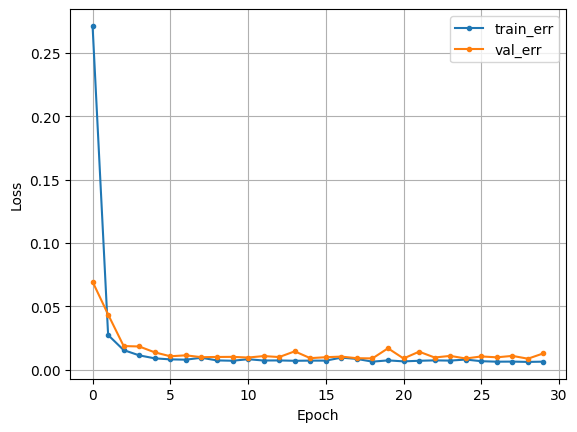

In [ ]:
dl_history_plot(hist)

In [ ]:
pred = model3.predict(x_val_s3)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

2/2 [==============================] - 0s 6ms/step


In [ ]:
# 평가
print('MAE :', mean_absolute_error(y_val, pred))
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', r2_score(y_val, pred))
print('RMSE :', np.sqrt(mean_squared_error(y_val, pred)))

MAE : 10.416657002766927
MAPE: 0.12339672871396458
R2  : 0.295779142005654
RMSE : 12.72096344458708


In [ ]:
# train에 대한 잔차 진단.
pred_tr = model3.predict(x_train_s3)

pred_tr = scaler_y.inverse_transform(pred_tr)
pred_tr = pred_tr.reshape(-1,)

# 잔차 : 실제값에서 예측값을 빼서 계산
residuals = y_train - pred_tr

34/34 [==============================] - 0s 3ms/step


* 정규성 검정(> 0.05) :  0.0
* 정상성 검정(< 0.05) :  2e-05
* 자기상관성 확인(ACF, PACF)


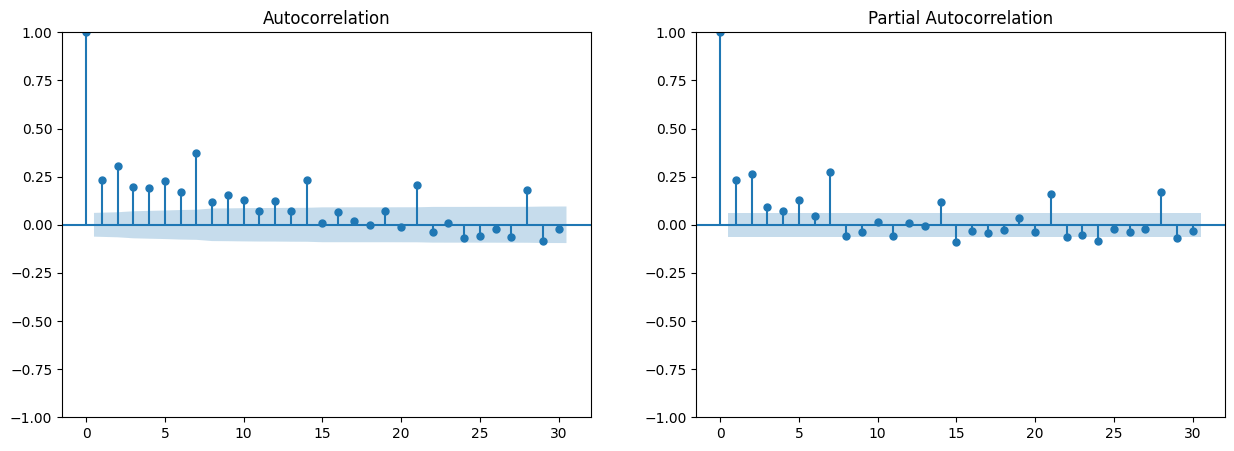

In [ ]:
residual_diag(residuals)

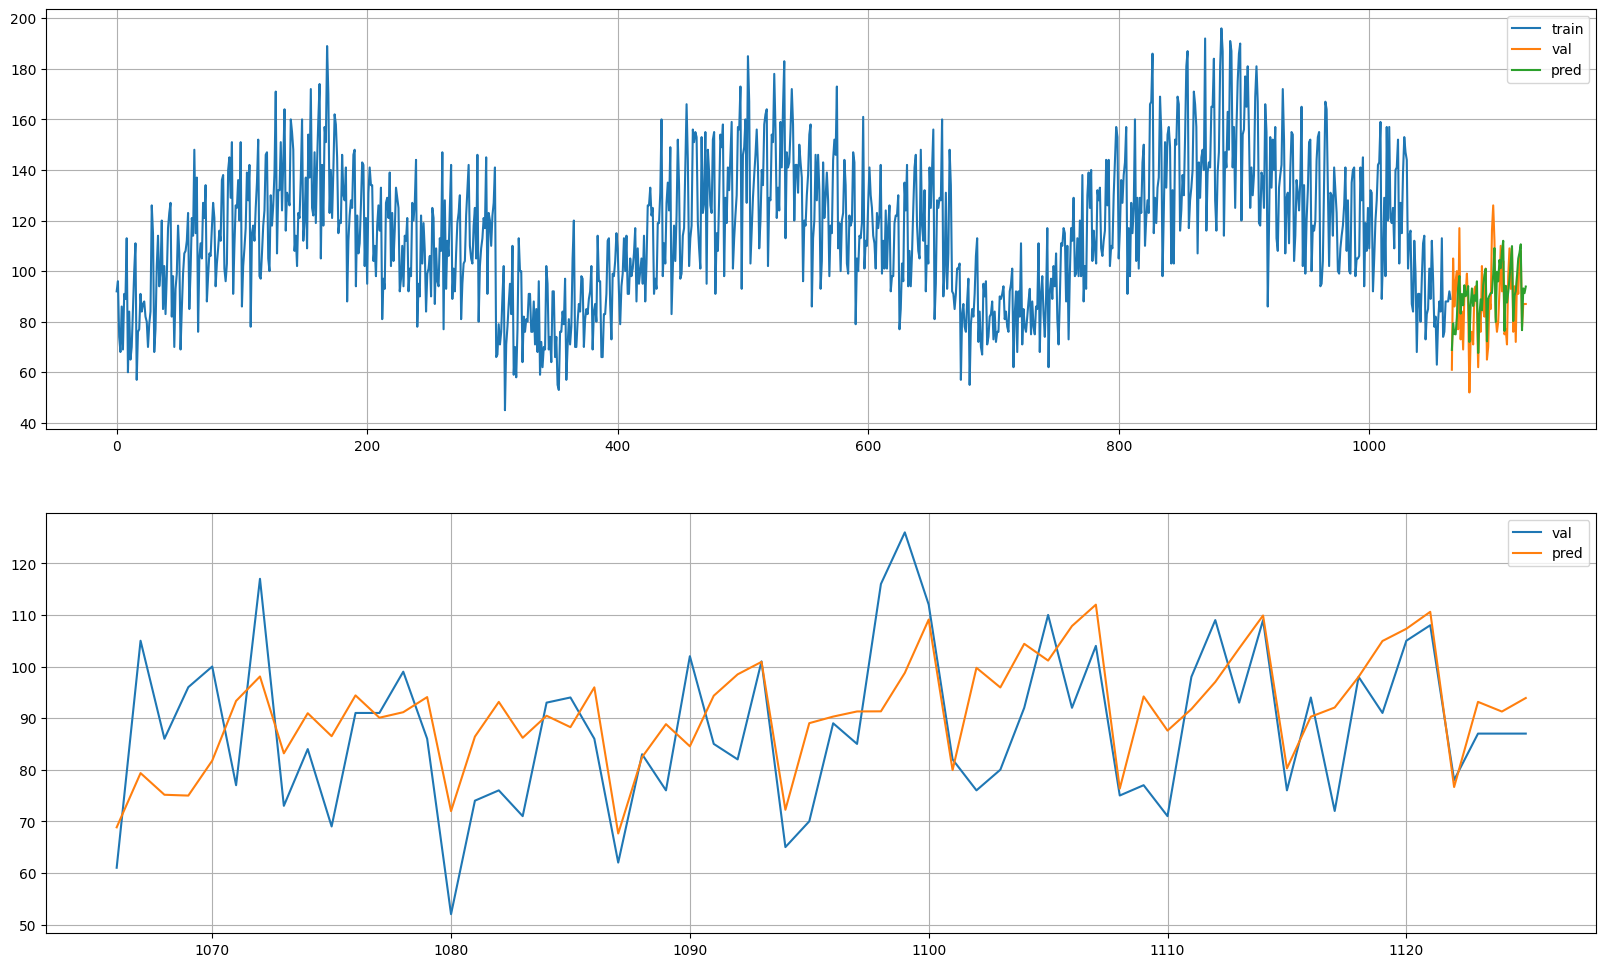

In [ ]:
plot_model_result(y_train, y_val, pred)

# **5.데이터 저장**

* **세부 요구사항**
    * 상품코드별 데이터셋을 저장하시오.
    * joblib.dump를 이용하시오.
    * 저장할 파일의 확장자는 보통 .pkl 입니다.

In [ ]:
# Product ID 3 데이터 저장
file_name = '3_beverage.pkl'
joblib.dump(df_44_3, file_name)

In [ ]:
# Product ID 12 데이터 저장
file_name = '12_milk.pkl'
joblib.dump(sales_44_12, file_name)

In [ ]:
# Product ID 42 데이터 저장
file_path = "df_gro.pkl"
joblib.dump(df_gro, file_path)